# Learning rate test

In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
from IPython.display import display, Markdown

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
DATA_DIR = os.path.abspath(os.path.join("data", "lrtest"))
MODELS_DIR = os.path.join(DATA_DIR, "models")
%mkdir -p $DATA_DIR $MODELS_DIR

# Test helpers

In [3]:
class SaveHistory(keras.callbacks.Callback):
    def __init__(self):
        self.batches = dict()
        self.epochs = dict()
        self.steps = list()
        self.train_ends = dict(batches=[], epochs=[])
        
    def _update(self, hist, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                hist.setdefault(k, []).append(logs[k].item())
    
    def on_batch_end(self, batch, logs={}):
        self._update(self.batches, logs)
    
    def on_epoch_end(self, epoch, logs={}):
        self._update(self.epochs, logs)
        
    def on_train_end(self, logs={}):
        nbatches = len(self.batches.get('loss', []))
        self.train_ends['batches'].append(nbatches)
        
        nepochs = len(self.epochs.get('loss', []))
        self.train_ends['epochs'].append(nepochs)

In [4]:
class AssignAndSetVal(object):
    LABELS = ['assign', 'setval']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    @classmethod
    def set2(cls, model, value):
        model.optimizer.lr.set_value(value)

In [5]:
class BothAssign(object):
    LABELS = ['assign-1', 'assign-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr = value
    
    set2 = set1

In [6]:
class BothSetVal(object):
    LABELS = ['setval-1', 'setval-2']
    
    @classmethod
    def set1(cls, model, value):
        model.optimizer.lr.set_value(value)
    
    set2 = set1

In [7]:
def validate_arg(name, value, valid_values):
    "Raise ValueError if value not in valid_values."
    if value not in valid_values:
        raise ValueError('{}={} is invalid. Valid values are {}.'.format(name, value, valid_values))

In [8]:
class LRTester(object):
    def __init__(self, model_factory, setter=AssignAndSetVal, optimizer=None,
                 batch_size=64, shuffle=False, verbose=1):
        self.factory = model_factory
        self.setter = setter
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.verbose = verbose
        self.reset() # initialize self.models, self.histories, and self.init_weights
            
    def getmodel(self):
        kwargs = dict()
        if self.optimizer is not None:
            kwargs["optimizer"] = self.optimizer
        return self.factory.getmodel(**kwargs)
        
    def _fname(self, suffix):
        return "%s/%s_%s.h5" % (MODELS_DIR, self.factory.__name__, suffix)
        
    def _save_models(self):
        for model, label in zip(self.models, self.setter.LABELS):
            model.save(self._fname(label + '_model'))
        return self
        
    def _load_models(self):
        self.models = [keras.models.load_model(self._fname(label + '_model'))
                       for label in self.setter.LABELS]
        return self
        
    def _save_histories(self):
        for hist, label in zip(self.histories, self.setter.LABELS):
            # Don't attempt to pickle hist.model, which might be huge.
            hist.model = None
            with open(self._fname(label + '_hist'), 'w') as f:
                pickle.dump(hist, f)
        return self
        
    def _load_histories(self):                
        self.histories = []
        for i, label in enumerate(self.setter.LABELS):
            with open(self._fname(label + '_hist')) as f:
                self.histories.append(pickle.load(f))
                self.histories[i].model = self.models[i]
        
        return self
        
    def save_state(self):
        self._save_models()
        self._save_histories()
        return self
        
    def load_state(self):
        self._load_models()
        self._load_histories()
        return self
        
    def _plotrow(self, axes, which, metric, hist1, hist2):
        ax_data, ax_delta = axes
        data1, data2 = getattr(hist1, which), getattr(hist2, which)
        ys1, ys2 = data1[metric], data2[metric]
        te1, te2 = hist1.train_ends[which], hist2.train_ends[which]
        label1, label2 = self.setter.LABELS
        color1, color2 = 'blue', 'red'
            
        def add_training_end_vlines(ax):
            for te in te1[:-1]:
                ax.axvline(te, linestyle='dotted', alpha=0.4, color=color1)
            for te in te2[:-1]: 
                ax.axvline(te, linestyle='dotted', alpha=0.4, color=color2)
                
        def plot_shifted_by(n, ax, ys, **kwargs):
            ax.plot(np.arange(n, len(ys)+n), ys, **kwargs)
        
        ax_data.set_ylabel(metric)
        plot_shifted_by(1, ax_data, ys1, alpha=0.6, color=color1, label=label1)
        plot_shifted_by(1, ax_data, ys2, alpha=0.6, color=color2, label=label2)
        add_training_end_vlines(ax_data)
        ax_data.legend(fontsize='small', labelspacing=0.2, loc=0)
        
        ax_delta.set_ylabel(metric + ' delta')
        deltas = np.array(ys1) - np.array(ys2)
        plot_shifted_by(1, ax_delta, deltas, color='green')
        add_training_end_vlines(ax_delta)
        
    def _get_fig_title(self, figname, hist1, hist2):
        
        def merge_if_equal(optname, v1, v2):
            if v1 == v2:
                fmt = "{optname}={v1};"
            else:
                fmt = "{optname}1={v1}; {optname}2={v2}"
            return fmt.format(optname=optname, v1=v1, v2=v2)
        
        opt1 = hist1.model.optimizer.__class__.__name__
        opt2 = hist2.model.optimizer.__class__.__name__
        
        title = "{} {}\n".format(self.factory.__name__, figname)
        opt = merge_if_equal("opt", opt1, opt2)
        steps = merge_if_equal("steps", hist1.steps, hist2.steps)
        
        return title + opt + ' ' + steps

        
    def makefig(self, which):
        hist1, hist2 = self.histories
        data1, data2 = getattr(hist1, which), getattr(hist2, which)
        
        if sorted(data1) != sorted(data2):
            raise RuntimeError("hist1 and hist2 do not contain the same metrics:\n"
                               "\tmetrics1={}\n\tmetrics2={}".format(data1, data2))
        
        nrows = len(data1)
        lastrow = nrows - 1
        thisrow = -1
        
        fig, axes = plt.subplots(nrows, 2, figsize=(12,2*nrows), sharex=True)
        fig.suptitle(self._get_fig_title(which, hist1, hist2))
        
        for metric in data1:
            thisrow += 1
            self._plotrow(axes[thisrow], which, metric, hist1, hist2)
            if thisrow == lastrow:
                axes[thisrow][0].set_xlabel(which)
                axes[thisrow][1].set_xlabel(which)
            
        plt.show()
        return self
                
    def makefigs(self):
        self.makefig('batches')
        self.makefig('epochs')
        return self
            
    def reset(self, which='both'):
        validate_arg('which', which, ['both', 'first', 'second'])
        if which == 'both':
            self.models = [self.getmodel(), self.getmodel()]
            self.init_weights = [np.copy(w) for w in self.models[0].get_weights()]
            self.models[1].set_weights(self.init_weights)
            self.histories = [SaveHistory(), SaveHistory()]
        elif which == 'first':
            self.models[0] = self.getmodel()
            self.models[0].set_weights(self.init_weights)
            self.histories[0] = SaveHistory()
        elif which == 'second':
            self.models[1] = self.getmodel()
            self.models[1].set_weights(self.init_weights)
            self.histories[1] = SaveHistory()
        
        return self
    
    def _run_steps(self, model, hist, steps, setfn, setlabel, step_callback):
        # Normalize each step to an (lr, nb_epoch) tuple, with nb_epoch defaulting to one.
        steps = [step if isinstance(step, tuple) else (step, 1) for step in steps]
        hist.steps.extend(steps)
        step_n = 0
        
        if self.verbose > 0:
            display(Markdown(
                "**Running {} with opt={}, setter={}, steps={}**".format(
                self.factory.__name__,
                model.optimizer.__class__.__name__,
                setlabel,
                steps
            )))
        
        for lr, nb_epoch in steps:
            step_n += 1
            
            if step_callback is not None:
                step_callback(step_n, model, lr, nb_epoch)
            
            if lr is not None:
                setfn(model, lr)
            
            self.factory.fitmodel(model, batch_size=self.batch_size, shuffle=self.shuffle,
                                  nb_epoch=nb_epoch, callbacks=[hist], verbose=self.verbose)
        
    def run(self, which='both', steps=None, steps1=None, steps2=None, step_callback=None):
        validate_arg('which', which, ['both', 'first', 'second'])
        
        if steps is not None:
            steps1 = steps2 = steps
        elif which == 'both' and (steps1 is None or steps2 is None):
            raise ValueError("Must specify either steps or both steps1 and steps2")
        elif which == 'first' and steps1 is None:
            raise ValueError("Must specify either steps or steps1")
        elif which == 'second' and steps2 is None:
            raise ValueError("Must specify either steps or steps2")
        
        model1, model2 = self.models
        hist1, hist2 = self.histories
        setlabel1, setlabel2 = self.setter.LABELS
        
        if which == 'both' or which == 'first':
            self._run_steps(model1, hist1, steps1, self.setter.set1, setlabel1, step_callback)
        
        if which == 'both' or which == 'second':
            self._run_steps(model2, hist2, steps2, self.setter.set2, setlabel2, step_callback)
        
        return self

In [9]:
def runtests(model_factory):
    # Don't use runtests. Use the more flexible "gocrazy", below.
    for opt in [Adam, SGD]:
        for setter in [AssignAndSetVal, BothSetVal, BothAssign]:
            t = LRTester(model_factory, setter=setter, optimizer=opt, verbose=0)
            t.run(steps=[(None, 1), (0.1, 1), (0.01, 1)])
            t.makefig('batches')

# MNIST

Test various models from `mnist.ipynb`.

## MNIST Setup

In [10]:
from keras.datasets import mnist
(X_train, y_train), (X_val, y_val) = mnist.load_data()
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

15204352/15296311 [============================>.] - ETA: 0s

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [11]:
X_val = np.expand_dims(X_val,1)
X_train = np.expand_dims(X_train,1)
y_train = onehot(y_train)
y_val = onehot(y_val)

In [12]:
def norm_input(x):
    mean_px = X_train.mean().astype(np.float32)
    std_px = X_train.std().astype(np.float32)
    return (x-mean_px)/std_px

## MNIST Linear

In [13]:
class MNIST_Linear(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Flatten(),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

## MNIST CNN with batchnorm + dropout + data augmentation

In [14]:
class MNIST_CNN_BN(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                                       height_shift_range=0.08, zoom_range=0.08)
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

## MNIST CNN with batchnorm, no dropout, no data augmentation

In [15]:
class MNIST_CNN_BN_NoDropout_NoDataAug(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Lambda(norm_input, input_shape=(1,28,28)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu'),
            MaxPooling2D(),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            Convolution2D(64,3,3, activation='relu'),
            MaxPooling2D(),
            Flatten(),
            BatchNormalization(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.0),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def _getbatches(cls, x=X_train, y=y_train, x_val=X_val, y_val=y_val, **kwargs):
        gen = image.ImageDataGenerator()
        batches = gen.flow(x, y, **kwargs)
        val_batches = gen.flow(x_val, y_val, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

# Dogs and Cats

## Dogs and Cats Setup

In [16]:
dogscats_path = os.path.join(DATA_DIR, 'dogscats')
dogscats_train_path = os.path.join(dogscats_path, 'train')
dogscats_valid_path = os.path.join(dogscats_path, 'valid')
#dogscats_train_path = os.path.join(dogscats_path, 'sample', 'train')
#dogscats_valid_path = os.path.join(dogscats_path, 'sample', 'valid')

In [17]:
if not os.path.exists(dogscats_path):
    dogscats_zip = get_file('dogscats.zip', 'http://files.fast.ai/data/dogscats.zip',
                            cache_subdir=DATA_DIR, md5_hash='aef22ec7d472dd60e8ee79eecc19f131')
    !unzip -q -d $DATA_DIR $dogscats_zip

856989696/857214334 [============================>.] - ETA: 0s

In [18]:
def vgg_preprocess(x):
    # Use fully qualified vgg16.vgg_mean to avoid
    #   NameError: global name 'vgg_mean' is not defined
    # when attempting to load the vgg16 model via keras.models.load_model.
    # References:
    # https://github.com/fchollet/keras/issues/5298
    # https://github.com/fchollet/keras/issues/4079
    import vgg16
    x = x - vgg16.vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

import vgg16
vgg16.vgg_preprocess = vgg_preprocess

## Dogs and Cats Vgg16

In [19]:
class DogsCats_Vgg16(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        vgg = Vgg16()
        batches, _ = cls._getbatches(batch_size=64, shuffle=False)
        vgg.finetune(batches)
        vgg.model.compile(optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return vgg.model
    
    @classmethod
    def _getbatches(cls, **kwargs):
        gen = image.ImageDataGenerator()
        kwargs['target_size'] = (224,224)
        kwargs['class_mode'] = 'categorical'
        batches = gen.flow_from_directory(dogscats_train_path, **kwargs)
        val_batches = gen.flow_from_directory(dogscats_valid_path, **kwargs)
        return batches, val_batches
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        batch_size = kwargs.pop('batch_size', 64)
        shuffle = kwargs.pop('shuffle', False)
        batches, val_batches = cls._getbatches(batch_size=batch_size, shuffle=shuffle)
        model.fit_generator(batches, batches.N, validation_data=val_batches, nb_val_samples=val_batches.N,
                            **kwargs)

## Dogs Cats Vgg16 No Dropout (Lesson 3)

In [20]:
dc_vgg = DogsCats_Vgg16.getmodel()
DogsCats_Vgg16.fitmodel(dc_vgg, nb_epoch=1, shuffle=True)

16384/35363 [============>.................] - ETA: 0sFound 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 616s - loss: 0.1195 - acc: 0.9677 - val_loss: 0.0625 - val_acc: 0.9810


In [21]:
dc_conv_layers, dc_fc_layers = split_at(dc_vgg, Convolution2D)
dc_conv_model = Sequential(dc_conv_layers)
dc_batches, dc_val_batches = DogsCats_Vgg16._getbatches(batch_size=64, shuffle=False)
dc_trn_labels = onehot(dc_batches.classes)
dc_val_labels = onehot(dc_val_batches.classes)
dc_trn_features = dc_conv_model.predict_generator(dc_batches, dc_batches.nb_sample)
dc_val_features = dc_conv_model.predict_generator(dc_val_batches, dc_val_batches.nb_sample)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [22]:
save_array(os.path.join(MODELS_DIR, 'dc_train_convlayer_features.bc'), dc_trn_features)
save_array(os.path.join(MODELS_DIR, 'dc_valid_convlayer_features.bc'), dc_val_features)

In [23]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def dogscats_nodropout_proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [24]:
class DogsCats_Vgg16_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=lambda: RMSprop(lr=0.00001, rho=0.7)):
        fc_model = Sequential([
            MaxPooling2D(input_shape=dc_conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(4096, activation='relu'),
            Dropout(0.),
            Dense(2, activation='softmax')
        ])
        for l1,l2 in zip(fc_model.layers, dc_fc_layers): l1.set_weights(dogscats_nodropout_proc_wgts(l2))

        fc_model.compile(optimizer=optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
        return fc_model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(dc_trn_features, dc_trn_labels, validation_data=(dc_val_features, dc_val_labels),
                  **kwargs)

# Lesson 4: IMDB Ratings

## IMDB Ratings Setup

In [25]:
movielens_path = os.path.join(DATA_DIR, 'ml-latest-small/')

In [26]:
if not os.path.exists(movielens_path):
    movielens_zip = get_file('ml-latest-small.zip',
                             'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
                             cache_subdir=DATA_DIR, md5_hash='be5b02baacd9e70dd97734ea0e19528a')
    !unzip -q -d $DATA_DIR $movielens_zip

917504/918269 [============================>.] - ETA: 0s

In [27]:
def imdb_embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [28]:
ml_ratings = pd.read_csv(movielens_path+'ratings.csv')
ml_movie_names = pd.read_csv(movielens_path+'movies.csv').set_index('movieId')['title'].to_dict()
ml_users = ml_ratings.userId.unique()
ml_movies = ml_ratings.movieId.unique()
ml_userid2idx = {o:i for i,o in enumerate(ml_users)}
ml_movieid2idx = {o:i for i,o in enumerate(ml_movies)}
ml_ratings.movieId = ml_ratings.movieId.apply(lambda x: ml_movieid2idx[x])
ml_ratings.userId = ml_ratings.userId.apply(lambda x: ml_userid2idx[x])
ml_n_users = ml_ratings.userId.nunique()
ml_n_movies = ml_ratings.movieId.nunique()
ml_n_factors = 50
np.random.seed = 42
msk = np.random.rand(len(ml_ratings)) < 0.8
ml_trn = ml_ratings[msk]
ml_val = ml_ratings[~msk]

## IMDB Ratings

In [29]:
class IMDB_Ratings(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        user_in, u = imdb_embedding_input('user_in', ml_n_users, ml_n_factors, 1e-4)
        movie_in, m = imdb_embedding_input('movie_in', ml_n_movies, ml_n_factors, 1e-4)
        x = merge([u, m], mode='concat')
        x = Flatten()(x)
        x = Dropout(0.3)(x)
        x = Dense(70, activation='relu')(x)
        x = Dropout(0.75)(x)
        x = Dense(1)(x)
        model = Model([user_in, movie_in], x)
        model.compile(optimizer=optimizer(), loss='mse', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit([ml_trn.userId, ml_trn.movieId], ml_trn.rating,
                  validation_data=([ml_val.userId, ml_val.movieId], ml_val.rating),
                  **kwargs)

In [30]:
class IMDB_Ratings_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        user_in, u = imdb_embedding_input('user_in', ml_n_users, ml_n_factors, 1e-4)
        movie_in, m = imdb_embedding_input('movie_in', ml_n_movies, ml_n_factors, 1e-4)
        x = merge([u, m], mode='concat')
        x = Flatten()(x)
        x = Dropout(0.0)(x)
        x = Dense(70, activation='relu')(x)
        x = Dropout(0.0)(x)
        x = Dense(1)(x)
        model = Model([user_in, movie_in], x)
        model.compile(optimizer=optimizer(), loss='mse', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit([ml_trn.userId, ml_trn.movieId], ml_trn.rating,
                  validation_data=([ml_val.userId, ml_val.movieId], ml_val.rating),
                  **kwargs)

# Lesson 5: IMDB Sentiment Analysis

## IMDB Sentiment Analysis Setup

In [31]:
from keras.datasets import imdb
imdb_idx = imdb.get_word_index()
imdb_idx_arr = sorted(imdb_idx, key=imdb_idx.get)
imdb_idx2word = {v: k for k, v in imdb_idx.iteritems()}

1990656/2343108 [========================>.....] - ETA: 0s

In [32]:
imdb_path = get_file('imdb_full.pkl',
                     origin='https://s3.amazonaws.com/text-datasets/imdb_full.pkl',
                     cache_subdir=DATA_DIR, md5_hash='d091312047c43cf9e4e38fef92437263')

65503232/65552540 [============================>.] - ETA: 0s

In [33]:
glove_path = get_file('6B.50d',
                      origin='http://files.fast.ai/models/glove/6B.50d.tgz',
                      cache_subdir=DATA_DIR, md5_hash='8e1557d1228decbda7db6dfd81cd9909',
                      untar=True)

80027648/80107627 [============================>.] - ETA: 0sUntaring file...


In [34]:
with open(imdb_path, 'rb') as f:
    (imdb_x_train, imdb_labels_train), (imdb_x_test, imdb_labels_test) = pickle.load(f)

imdb_vocab_size = 5000
imdb_trn = [np.array([i if i<imdb_vocab_size-1 else imdb_vocab_size-1 for i in s]) for s in imdb_x_train]
imdb_test = [np.array([i if i<imdb_vocab_size-1 else imdb_vocab_size-1 for i in s]) for s in imdb_x_test]

imdb_seq_len = 500
imdb_trn = sequence.pad_sequences(imdb_trn, maxlen=imdb_seq_len, value=0)
imdb_test = sequence.pad_sequences(imdb_test, maxlen=imdb_seq_len, value=0)

In [35]:
def glove_load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

In [36]:
glove_vecs, glove_words, glove_wordidx = glove_load_vectors(glove_path)

In [37]:
def imdb_create_emb():
    n_fact = glove_vecs.shape[1]
    emb = np.zeros((imdb_vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = imdb_idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            src_idx = glove_wordidx[word]
            emb[i] = glove_vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [38]:
def set_layer_trainable(on_step, layer, trainable):
    def step_callback(step_n, model, lr, nb_epoch):
        if step_n == on_step:
            model.layers[layer].trainable = trainable
    return step_callback

## IMDB Sentiment Analysis CNN

In [39]:
class IMDB_Sentiment_Analysis(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.2, 
                      weights=[emb], trainable=False),
            Dropout(0.25),
            Convolution1D(64, 5, border_mode='same', activation='relu'),
            Dropout(0.25),
            MaxPooling1D(),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.7),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

In [40]:
class IMDB_Sentiment_Analysis_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.0,
                      weights=[emb], trainable=False),
            Dropout(0.0),
            Convolution1D(64, 5, border_mode='same', activation='relu'),
            Dropout(0.0),
            MaxPooling1D(),
            Flatten(),
            Dense(100, activation='relu'),
            Dropout(0.0),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

## IMDB Sentiment Analysis Multi CNN

In [41]:
from keras.layers import Merge

In [42]:
class IMDB_Sentiment_Analysis_Multi_CNN(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        graph_in = Input((imdb_vocab_size, 50))
        convs = [] 
        for fsz in range (3, 6): 
            x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
            x = MaxPooling1D()(x) 
            x = Flatten()(x) 
            convs.append(x)
        out = Merge(mode="concat")(convs) 
        graph = Model(graph_in, out)
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.2, weights=[emb]),
            Dropout(0.2),
            graph,
            Dropout(0.5),
            Dense(100, activation="relu"),
            Dropout(0.7),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

In [43]:
class IMDB_Sentiment_Analysis_Multi_CNN_NoDropout(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        graph_in = Input((imdb_vocab_size, 50))
        convs = [] 
        for fsz in range (3, 6): 
            x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
            x = MaxPooling1D()(x) 
            x = Flatten()(x) 
            convs.append(x)
        out = Merge(mode="concat")(convs) 
        graph = Model(graph_in, out)
        emb = imdb_create_emb()
        model = Sequential([
            Embedding(imdb_vocab_size, 50, input_length=imdb_seq_len, dropout=0.0, weights=[emb]),
            Dropout(0.0),
            graph,
            Dropout(0.0),
            Dense(100, activation="relu"),
            Dropout(0.0),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizer(), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        model.fit(imdb_trn, imdb_labels_train, validation_data=(imdb_test, imdb_labels_test), **kwargs)

# Lesson 6: Nietzsche Postmodernism Generator RNN

In [44]:
nietzsche_path = get_file('nietzsche.txt',
                          origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt",
                          cache_subdir=DATA_DIR)

475136/600901 [======================>.......] - ETA: 0s

In [45]:
nietzsche_text = open(nietzsche_path).read()
nietzsche_chars = sorted(list(set(nietzsche_text)))
nietzsche_vocab_size = len(nietzsche_chars)+1
nietzsche_chars.insert(0, "\0")
nietzsche_char_indices = dict((c, i) for i, c in enumerate(nietzsche_chars))
nietzsche_indices_char = dict((i, c) for i, c in enumerate(nietzsche_chars))
nietzsche_idx = [nietzsche_char_indices[c] for c in nietzsche_text]
nietzsche_n_fac = 42
nietzsche_n_hidden = 256

## Nietzsche 3-char model

In [46]:
def neitzsche_embedding_input_3char(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name)
    emb = Embedding(n_in, n_out, input_length=1)(inp)
    return inp, Flatten()(emb)

In [47]:
class Nietzsche_3Char(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        embedding_input = neitzsche_embedding_input_3char
        c1_in, c1 = embedding_input('c1', nietzsche_vocab_size, nietzsche_n_fac)
        c2_in, c2 = embedding_input('c2', nietzsche_vocab_size, nietzsche_n_fac)
        c3_in, c3 = embedding_input('c3', nietzsche_vocab_size, nietzsche_n_fac)
        
        dense_in = Dense(nietzsche_n_hidden, activation='relu')
        dense_hidden = Dense(nietzsche_n_hidden, activation='tanh')
        dense_out = Dense(nietzsche_vocab_size, activation='softmax')

        c1_hidden = dense_in(c1)
        c2_dense = dense_in(c2)
        hidden_2 = dense_hidden(c1_hidden)
        c2_hidden = merge([c2_dense, hidden_2])
        
        c3_dense = dense_in(c3)
        hidden_3 = dense_hidden(c2_hidden)
        c3_hidden = merge([c3_dense, hidden_3])
        
        c4_out = dense_out(c3_hidden)
        
        model = Model([c1_in, c2_in, c3_in], c4_out)
        model.compile(optimizer=optimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        cs=3
        c1_dat = [nietzsche_idx[i]   for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        c2_dat = [nietzsche_idx[i+1] for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        c3_dat = [nietzsche_idx[i+2] for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        c4_dat = [nietzsche_idx[i+3] for i in xrange(0, len(nietzsche_idx)-1-cs, cs)]
        
        x1 = np.stack(c1_dat[:-2])
        x2 = np.stack(c2_dat[:-2])
        x3 = np.stack(c3_dat[:-2])
        y = np.stack(c4_dat[:-2])
        
        model.fit([x1, x2, x3], y, **kwargs)

In [48]:
def nietzsche_get_next_3char(model, inp):
    idxs = [nietzsche_char_indices[c] for c in inp]
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    p = model.predict(arrs)
    i = np.argmax(p)
    return nietzsche_chars[i]

In [49]:
def nietzsche_compare_3char(model1, model2, inputs):
    results = []
    for inp in inputs:
        result = (nietzsche_get_next_3char(model1, inp), nietzsche_get_next_3char(model2, inp))
        results.append(result)
    return results

## Nietzsche RNN returing sequences

In [50]:
nietzsche_cs = 8

In [51]:
class Nietzsche_RNN_Keras_Sequences(object):    
    @classmethod
    def getmodel(cls, optimizer=Adam):
        model = Sequential([
            Embedding(nietzsche_vocab_size, nietzsche_n_fac, input_length=nietzsche_cs),
            SimpleRNN(nietzsche_n_hidden, return_sequences=True, activation='relu', inner_init='identity'),
            TimeDistributed(Dense(nietzsche_vocab_size, activation='softmax')),
        ])
        model.compile(optimizer=optimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    @classmethod
    def fitmodel(cls, model, **kwargs):
        cs = nietzsche_cs
        idx = nietzsche_idx
        
        c_in_dat = [[idx[i+n] for i in xrange(0, len(idx)-1-cs, cs)]
                    for n in range(cs)]
        
        c_out_dat = [[idx[i+n] for i in xrange(1, len(idx)-cs, cs)]
                     for n in range(cs)]
        
        xs = [np.stack(c[:-2]) for c in c_in_dat]
        ys = [np.stack(c[:-2]) for c in c_out_dat]
        x_rnn=np.stack(xs, axis=1)
        y_rnn=np.expand_dims(np.stack(ys, axis=1), -1)
        
        model.fit(x_rnn, y_rnn, **kwargs)

In [52]:
def nietzsche_get_nexts_keras(model, inp):
    idxs = [nietzsche_char_indices[c] for c in inp]
    arr = np.array(idxs)[np.newaxis,:]
    p = model.predict(arr)[0]
    print(list(inp))
    return [nietzsche_chars[np.argmax(o)] for o in p]

# Lesson 7: Fisheries

T.B.D.

# Test Results

## GPU Results

This section contains results for tests run on an amazon p2-xlarge instance's GPU.

## GPU Results: by the book

The test resutls in this "by the book" section attempt to replicate the results the from the corresponding course notebook. That is, they use the same sequence of learning-rate changes, nb_epochs, batch_size, etc., as those found in the corresponding notebook. The idea is to make it easy to determine the effect of different learning-rate assigment strategies for a particular lesson. For this reason, the tests in this section only run using the `AssignAndSetVal` strategy, never using `BothAssign` or `BothSetVal`, and they always use exactly the same sequence of learning-rate changes and nb_epochs for both the "assign" model and the "set_value" model.

In rare cases where the lesson notebook only runs fit on a model with a single, default learning rate, I add at least one learning rate change so there is something to compare.

For models that include dropout and/or data augmentation, I also include a variant without either, as way to remove some randomness and make it easier to compare apples-to-apples. Most of these `NoDropout` and `NoDataAug` variants are tested with `shuffle=False`. The exceptions are the binary classifiers, such as `DogsCats_Vgg16_NoDropout`, `IMDB_Sentiment_Analysis_NoDropout`, and `IMDB_Sentiment_Analysis_Multi_CNN_NoDropout`, since validation accuracy for these models tends to get stuck at 50% when `shuffle=False`, presumably because the model is stuck consistenly guessing one or the other of the two classes.

### GPU Results: MNIST Linear Model

**Running MNIST_Linear with opt=Adam, setter=assign, steps=[(None, 1), (0.1, 1), (0.01, 4)]**

Epoch 1/1
60000/60000 [==============================] - 11s - loss: 0.4212 - acc: 0.8748 - val_loss: 0.2896 - val_acc: 0.9202
Epoch 1/1
60000/60000 [==============================] - 11s - loss: 0.2980 - acc: 0.9152 - val_loss: 0.2887 - val_acc: 0.9164
Epoch 1/4
60000/60000 [==============================] - 11s - loss: 0.2850 - acc: 0.9191 - val_loss: 0.2799 - val_acc: 0.9241
Epoch 2/4
60000/60000 [==============================] - 11s - loss: 0.2771 - acc: 0.9221 - val_loss: 0.2810 - val_acc: 0.9212
Epoch 3/4
60000/60000 [==============================] - 11s - loss: 0.2726 - acc: 0.9228 - val_loss: 0.2781 - val_acc: 0.9229
Epoch 4/4
60000/60000 [==============================] - 11s - loss: 0.2692 - acc: 0.9253 - val_loss: 0.2781 - val_acc: 0.9219


**Running MNIST_Linear with opt=Adam, setter=setval, steps=[(None, 1), (0.1, 1), (0.01, 4)]**

Epoch 1/1
60000/60000 [==============================] - 11s - loss: 0.4204 - acc: 0.8743 - val_loss: 0.3030 - val_acc: 0.9124
Epoch 1/1
60000/60000 [==============================] - 11s - loss: 4.5282 - acc: 0.7064 - val_loss: 4.1779 - val_acc: 0.7336
Epoch 1/4
60000/60000 [==============================] - 11s - loss: 4.0681 - acc: 0.7418 - val_loss: 3.9027 - val_acc: 0.7527
Epoch 2/4
60000/60000 [==============================] - 11s - loss: 3.9860 - acc: 0.7471 - val_loss: 3.8393 - val_acc: 0.7563
Epoch 3/4
60000/60000 [==============================] - 11s - loss: 3.9376 - acc: 0.7504 - val_loss: 3.8716 - val_acc: 0.7538
Epoch 4/4
60000/60000 [==============================] - 11s - loss: 3.8896 - acc: 0.7535 - val_loss: 3.7546 - val_acc: 0.7619


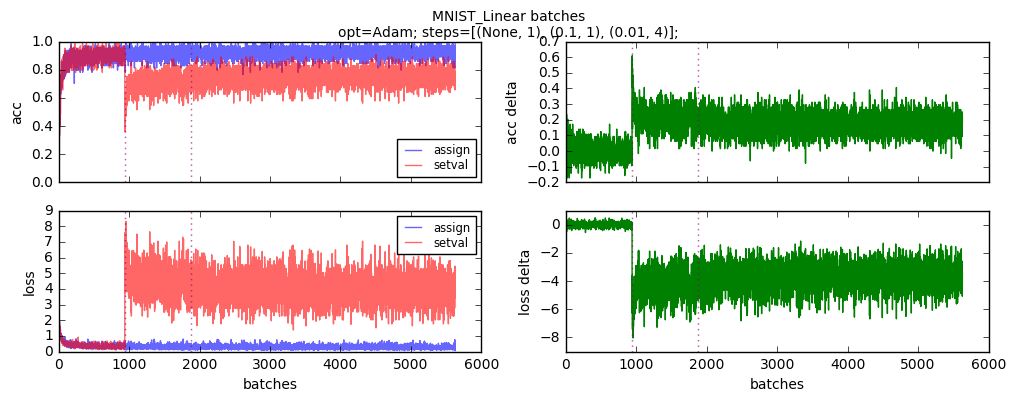

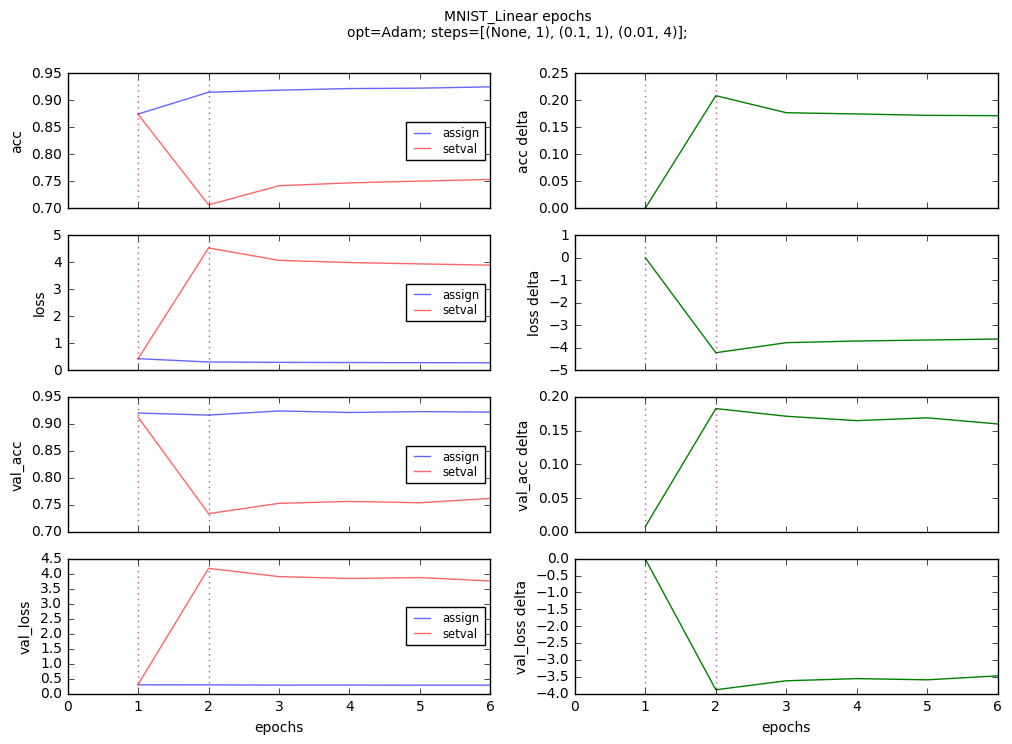

In [53]:
LRTester(MNIST_Linear, shuffle=True).run(steps=[None, 0.1, (0.01, 4)]).makefigs()

### GPU Results: MNIST CNN with batchnorm + dropout + data augmentation

**Running MNIST_CNN_BN with opt=Adam, setter=assign, steps=[(None, 1), (0.1, 4), (0.01, 12), (0.001, 1)]**

Epoch 1/1
60000/60000 [==============================] - 48s - loss: 0.2256 - acc: 0.9328 - val_loss: 0.0702 - val_acc: 0.9760
Epoch 1/4
60000/60000 [==============================] - 48s - loss: 0.0961 - acc: 0.9701 - val_loss: 0.0547 - val_acc: 0.9829
Epoch 2/4
60000/60000 [==============================] - 47s - loss: 0.0740 - acc: 0.9770 - val_loss: 0.0552 - val_acc: 0.9815
Epoch 3/4
60000/60000 [==============================] - 48s - loss: 0.0678 - acc: 0.9802 - val_loss: 0.0371 - val_acc: 0.9878
Epoch 4/4
60000/60000 [==============================] - 48s - loss: 0.0617 - acc: 0.9807 - val_loss: 0.0374 - val_acc: 0.9876
Epoch 1/12
60000/60000 [==============================] - 47s - loss: 0.0582 - acc: 0.9827 - val_loss: 0.0343 - val_acc: 0.9900
Epoch 2/12
60000/60000 [==============================] - 47s - loss: 0.0541 - acc: 0.9834 - val_loss: 0.0370 - val_acc: 0.9876
Epoch 3/12
60000/60000 [==============================] - 48s - loss: 0.0496 - acc: 0.9852 - val_loss: 0.0342

**Running MNIST_CNN_BN with opt=Adam, setter=setval, steps=[(None, 1), (0.1, 4), (0.01, 12), (0.001, 1)]**

Epoch 1/1
60000/60000 [==============================] - 48s - loss: 0.2262 - acc: 0.9336 - val_loss: 0.0685 - val_acc: 0.9782
Epoch 1/4
60000/60000 [==============================] - 47s - loss: 11.2015 - acc: 0.3009 - val_loss: 10.8752 - val_acc: 0.3248
Epoch 2/4
60000/60000 [==============================] - 48s - loss: 11.0761 - acc: 0.3123 - val_loss: 10.0579 - val_acc: 0.3757
Epoch 3/4
60000/60000 [==============================] - 48s - loss: 10.4454 - acc: 0.3517 - val_loss: 14.7642 - val_acc: 0.0840
Epoch 4/4
60000/60000 [==============================] - 47s - loss: 11.0125 - acc: 0.3166 - val_loss: 10.7746 - val_acc: 0.3315
Epoch 1/12
60000/60000 [==============================] - 48s - loss: 10.3481 - acc: 0.3579 - val_loss: 9.5113 - val_acc: 0.4095
Epoch 2/12
60000/60000 [==============================] - 47s - loss: 9.5449 - acc: 0.4076 - val_loss: 9.0726 - val_acc: 0.4371
Epoch 3/12
60000/60000 [==============================] - 47s - loss: 9.1152 - acc: 0.4343 - val_los

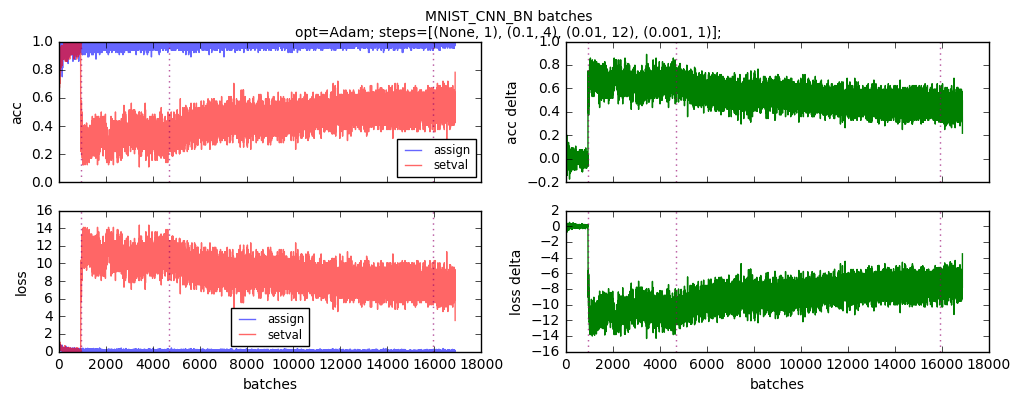

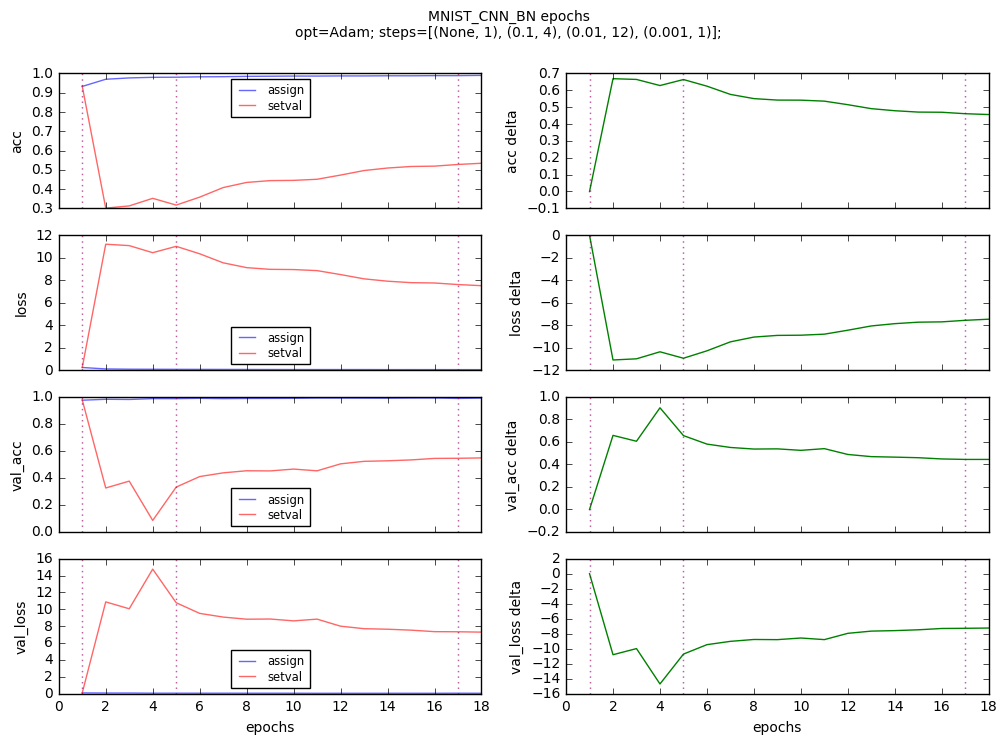

In [54]:
LRTester(MNIST_CNN_BN, shuffle=True).run(steps=[None, (0.1, 4), (0.01, 12), 0.001]).makefigs()

### GPU Results: MNIST CNN with batchnorm, no dropout, no data augmentation

**Running MNIST_CNN_BN_NoDropout_NoDataAug with opt=Adam, setter=assign, steps=[(None, 1), (0.1, 4), (0.01, 1), (0.001, 1)]**

Epoch 1/1
60000/60000 [==============================] - 47s - loss: 0.0921 - acc: 0.9724 - val_loss: 0.0408 - val_acc: 0.9861
Epoch 1/4
60000/60000 [==============================] - 47s - loss: 0.0315 - acc: 0.9905 - val_loss: 0.0325 - val_acc: 0.9908
Epoch 2/4
60000/60000 [==============================] - 46s - loss: 0.0196 - acc: 0.9942 - val_loss: 0.0343 - val_acc: 0.9903
Epoch 3/4
60000/60000 [==============================] - 46s - loss: 0.0167 - acc: 0.9945 - val_loss: 0.0396 - val_acc: 0.9887
Epoch 4/4
60000/60000 [==============================] - 46s - loss: 0.0161 - acc: 0.9949 - val_loss: 0.0375 - val_acc: 0.9897
Epoch 1/1
60000/60000 [==============================] - 46s - loss: 0.0110 - acc: 0.9961 - val_loss: 0.0373 - val_acc: 0.9893
Epoch 1/1
60000/60000 [==============================] - 47s - loss: 0.0083 - acc: 0.9974 - val_loss: 0.0442 - val_acc: 0.9892


**Running MNIST_CNN_BN_NoDropout_NoDataAug with opt=Adam, setter=setval, steps=[(None, 1), (0.1, 4), (0.01, 1), (0.001, 1)]**

Epoch 1/1
60000/60000 [==============================] - 47s - loss: 0.0916 - acc: 0.9724 - val_loss: 0.0403 - val_acc: 0.9875
Epoch 1/4
60000/60000 [==============================] - 46s - loss: 11.2465 - acc: 0.3005 - val_loss: 10.1573 - val_acc: 0.3696
Epoch 2/4
60000/60000 [==============================] - 45s - loss: 11.3424 - acc: 0.2962 - val_loss: 12.7715 - val_acc: 0.2071
Epoch 3/4
60000/60000 [==============================] - 45s - loss: 11.8232 - acc: 0.2664 - val_loss: 10.8431 - val_acc: 0.3272
Epoch 4/4
60000/60000 [==============================] - 46s - loss: 10.9639 - acc: 0.3197 - val_loss: 11.0731 - val_acc: 0.3130
Epoch 1/1
60000/60000 [==============================] - 46s - loss: 10.8437 - acc: 0.3272 - val_loss: 10.7040 - val_acc: 0.3359
Epoch 1/1
60000/60000 [==============================] - 46s - loss: 10.7386 - acc: 0.3337 - val_loss: 10.6315 - val_acc: 0.3404


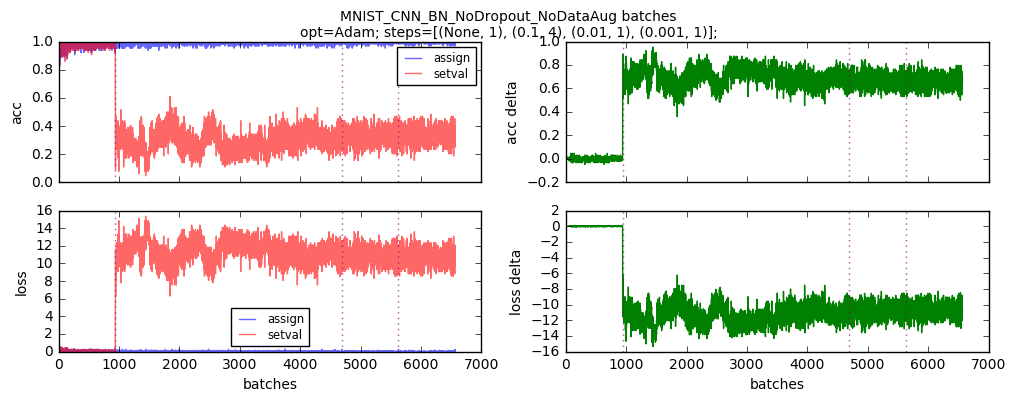

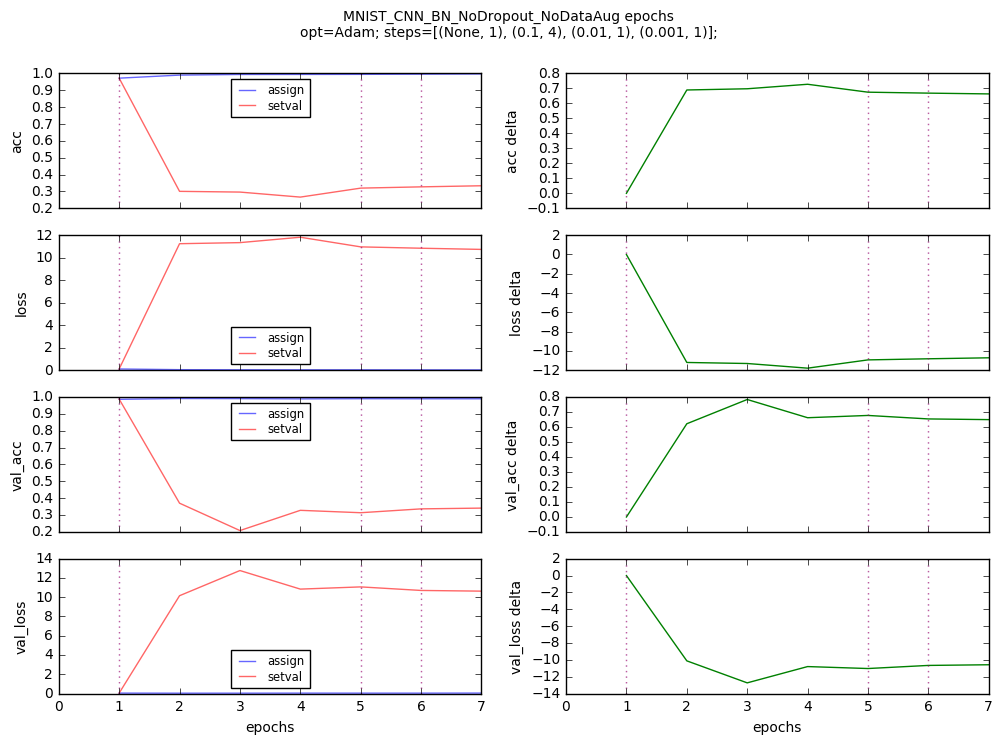

In [55]:
LRTester(MNIST_CNN_BN_NoDropout_NoDataAug, shuffle=False).run(steps=[None, (0.1, 4), 0.01, 0.001]).makefigs()

### GPU Results: DogsCats Vgg16

The `DogsCats_Vgg16` model is explored multiple times across lessons 1-3 and the `dogs_cats_redux` notebook. Just go with a "standard" learning rate progression of `steps=[None, 0.1, 0.001]`.

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


**Running DogsCats_Vgg16 with opt=Adam, setter=assign, steps=[(None, 1), (0.1, 1), (0.001, 1)]**

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 615s - loss: 0.1221 - acc: 0.9685 - val_loss: 0.0658 - val_acc: 0.9825
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 614s - loss: 0.0930 - acc: 0.9780 - val_loss: 0.0682 - val_acc: 0.9830
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 614s - loss: 0.0941 - acc: 0.9788 - val_loss: 0.0704 - val_acc: 0.9815


**Running DogsCats_Vgg16 with opt=Adam, setter=setval, steps=[(None, 1), (0.1, 1), (0.001, 1)]**

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 614s - loss: 0.1219 - acc: 0.9693 - val_loss: 0.0521 - val_acc: 0.9825
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 607s - loss: 8.0314 - acc: 0.5011 - val_loss: 8.0590 - val_acc: 0.5000
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 605s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


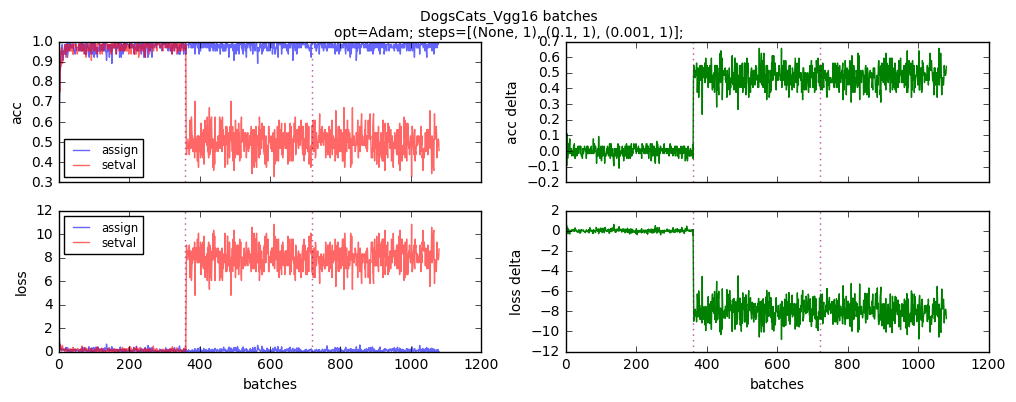

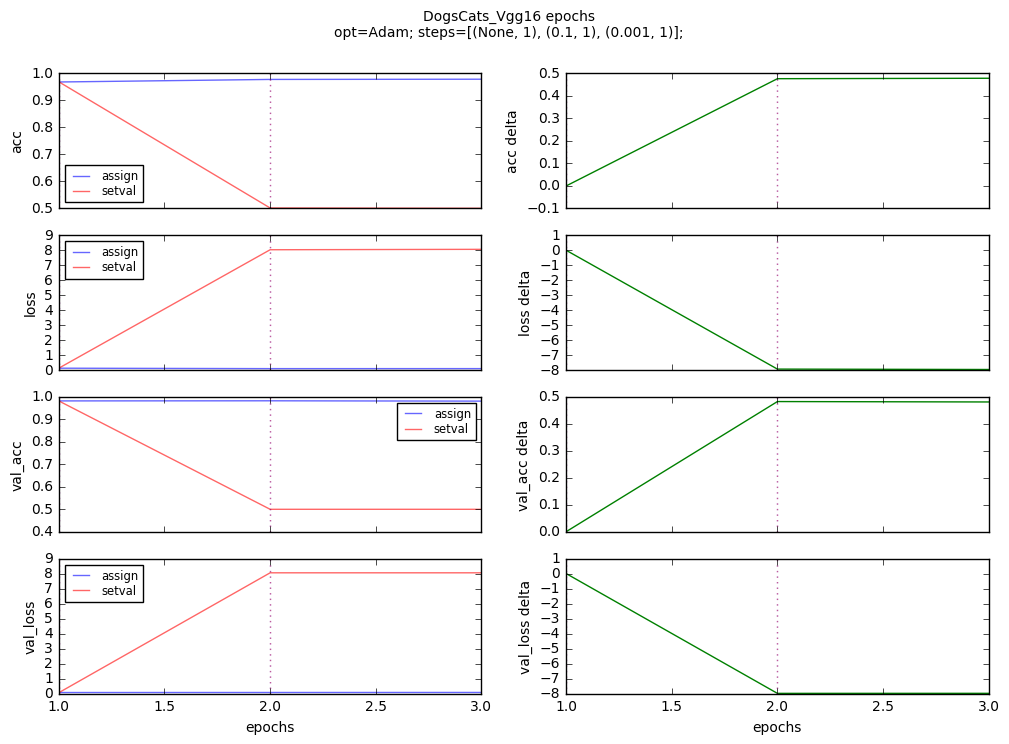

In [56]:
LRTester(DogsCats_Vgg16, shuffle=True).run(steps=[None, 0.1, 0.001]).makefigs()

### GPU Results: DogsCats Vgg16 No Dropout

In the lesson 3 notebook, the DogsCats model without dropout is run for 8 epochs without ever changing the learning rate. Therefore, add a single learning rate change after the 8 initial epochs, to make the test more interesting.

**Running DogsCats_Vgg16_NoDropout with opt=RMSprop, setter=assign, steps=[(None, 8), (0.1, 1)]**

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 33s - loss: 0.0435 - acc: 0.9853 - val_loss: 0.0432 - val_acc: 0.9870
Epoch 2/8
23000/23000 [==============================] - 34s - loss: 0.0132 - acc: 0.9966 - val_loss: 0.0534 - val_acc: 0.9875
Epoch 3/8
23000/23000 [==============================] - 34s - loss: 0.0062 - acc: 0.9992 - val_loss: 0.0642 - val_acc: 0.9870
Epoch 4/8
23000/23000 [==============================] - 34s - loss: 0.0040 - acc: 0.9997 - val_loss: 0.0975 - val_acc: 0.9850
Epoch 5/8
23000/23000 [==============================] - 34s - loss: 0.0039 - acc: 0.9997 - val_loss: 0.0873 - val_acc: 0.9870
Epoch 6/8
23000/23000 [==============================] - 33s - loss: 0.0039 - acc: 0.9997 - val_loss: 0.0923 - val_acc: 0.9870
Epoch 7/8
23000/23000 [==============================] - 33s - loss: 0.0040 - acc: 0.9997 - val_loss: 0.0911 - val_acc: 0.9870
Epoch 8/8
23000/23000 [==============================] - 33s -

**Running DogsCats_Vgg16_NoDropout with opt=RMSprop, setter=setval, steps=[(None, 8), (0.1, 1)]**

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 33s - loss: 0.0439 - acc: 0.9854 - val_loss: 0.0453 - val_acc: 0.9855
Epoch 2/8
23000/23000 [==============================] - 34s - loss: 0.0147 - acc: 0.9964 - val_loss: 0.0558 - val_acc: 0.9860
Epoch 3/8
23000/23000 [==============================] - 34s - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0707 - val_acc: 0.9870
Epoch 4/8
23000/23000 [==============================] - 34s - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0832 - val_acc: 0.9870
Epoch 5/8
23000/23000 [==============================] - 34s - loss: 0.0035 - acc: 0.9997 - val_loss: 0.0908 - val_acc: 0.9875
Epoch 6/8
23000/23000 [==============================] - 33s - loss: 0.0033 - acc: 0.9997 - val_loss: 0.0887 - val_acc: 0.9880
Epoch 7/8
23000/23000 [==============================] - 33s - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0917 - val_acc: 0.9855
Epoch 8/8
23000/23000 [==============================] - 33s -

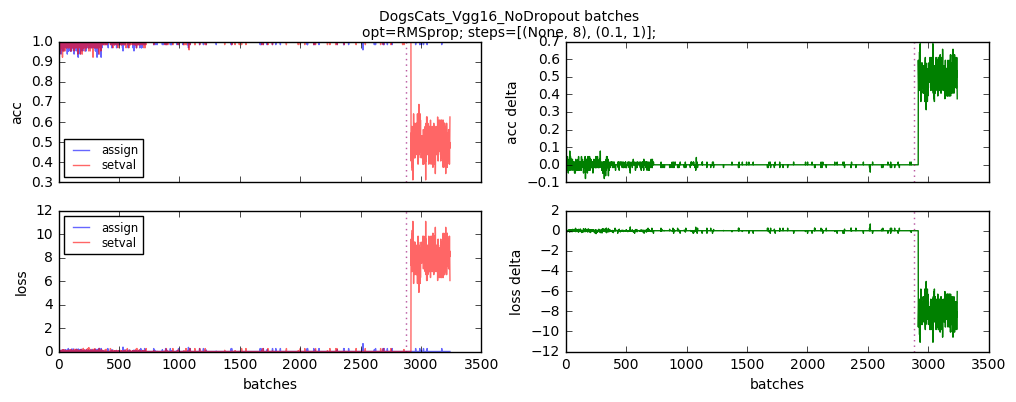

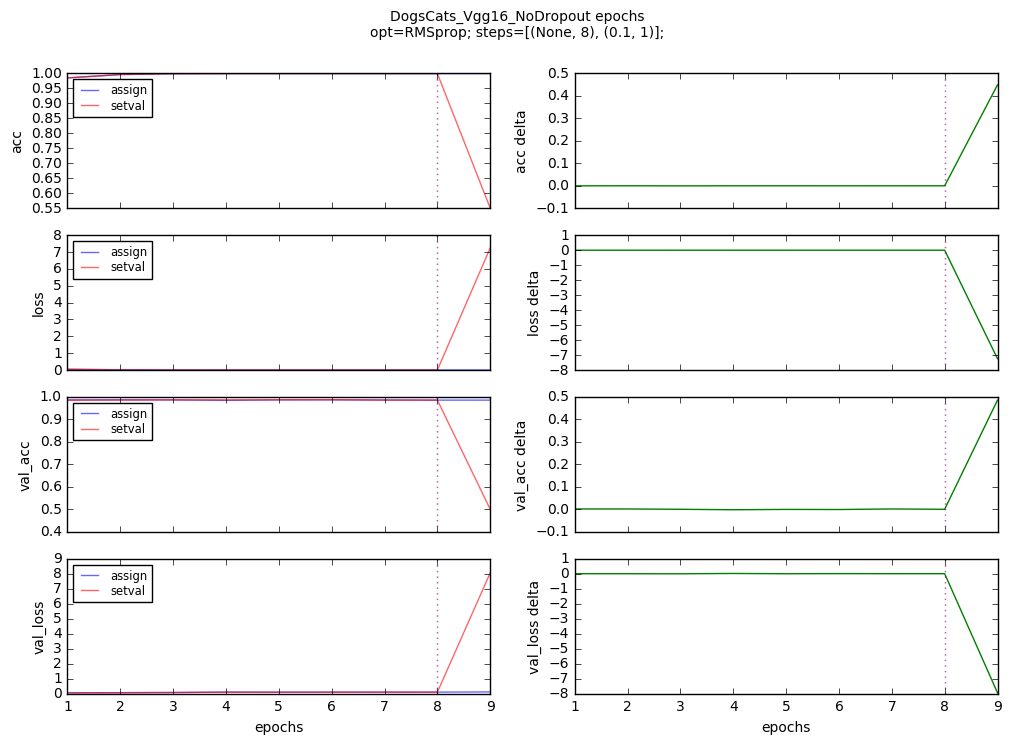

In [57]:
LRTester(DogsCats_Vgg16_NoDropout, shuffle=True).run(steps=[(None, 8), 0.1]).makefigs()

### GPU Results: IMDB Ratings NN

As with `DogsCats_Vgg16_NoDropout` above, add a single learning rate change after the 8 initial epochs, to make the test more interesting.

**Running IMDB_Ratings with opt=Adam, setter=assign, steps=[(None, 8), (0.1, 1)]**

Train on 79753 samples, validate on 20251 samples
Epoch 1/8
79753/79753 [==============================] - 7s - loss: 2.3381 - acc: 0.2008 - val_loss: 0.8582 - val_acc: 0.3038
Epoch 2/8
79753/79753 [==============================] - 7s - loss: 1.4109 - acc: 0.2389 - val_loss: 0.8345 - val_acc: 0.3091
Epoch 3/8
79753/79753 [==============================] - 7s - loss: 1.2025 - acc: 0.2610 - val_loss: 0.8144 - val_acc: 0.3151
Epoch 4/8
79753/79753 [==============================] - 7s - loss: 1.0279 - acc: 0.2879 - val_loss: 0.8003 - val_acc: 0.3215
Epoch 5/8
79753/79753 [==============================] - 7s - loss: 0.9169 - acc: 0.3068 - val_loss: 0.7934 - val_acc: 0.3220
Epoch 6/8
79753/79753 [==============================] - 7s - loss: 0.8497 - acc: 0.3206 - val_loss: 0.7866 - val_acc: 0.3249
Epoch 7/8
79753/79753 [==============================] - 7s - loss: 0.8233 - acc: 0.3330 - val_loss: 0.7830 - val_acc: 0.3285
Epoch 8/8
79753/79753 [==============================] - 7s - loss: 

**Running IMDB_Ratings with opt=Adam, setter=setval, steps=[(None, 8), (0.1, 1)]**

Train on 79753 samples, validate on 20251 samples
Epoch 1/8
79753/79753 [==============================] - 7s - loss: 2.3445 - acc: 0.1977 - val_loss: 0.8662 - val_acc: 0.2988
Epoch 2/8
79753/79753 [==============================] - 7s - loss: 1.4045 - acc: 0.2410 - val_loss: 0.8382 - val_acc: 0.3009
Epoch 3/8
79753/79753 [==============================] - 7s - loss: 1.1960 - acc: 0.2606 - val_loss: 0.8124 - val_acc: 0.3143
Epoch 4/8
79753/79753 [==============================] - 7s - loss: 1.0330 - acc: 0.2878 - val_loss: 0.8005 - val_acc: 0.3234
Epoch 5/8
79753/79753 [==============================] - 7s - loss: 0.9177 - acc: 0.3058 - val_loss: 0.7887 - val_acc: 0.3277
Epoch 6/8
79753/79753 [==============================] - 7s - loss: 0.8485 - acc: 0.3213 - val_loss: 0.7860 - val_acc: 0.3283
Epoch 7/8
79753/79753 [==============================] - 7s - loss: 0.8206 - acc: 0.3310 - val_loss: 0.7811 - val_acc: 0.3357
Epoch 8/8
79753/79753 [==============================] - 7s - loss: 

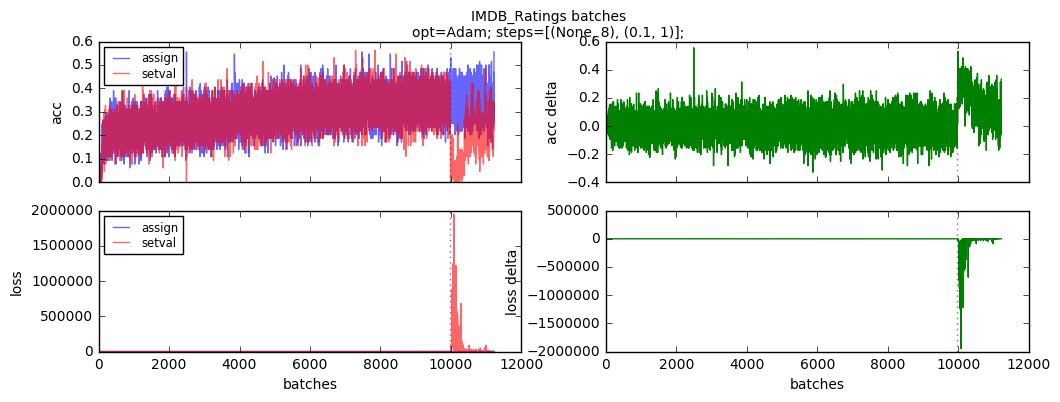

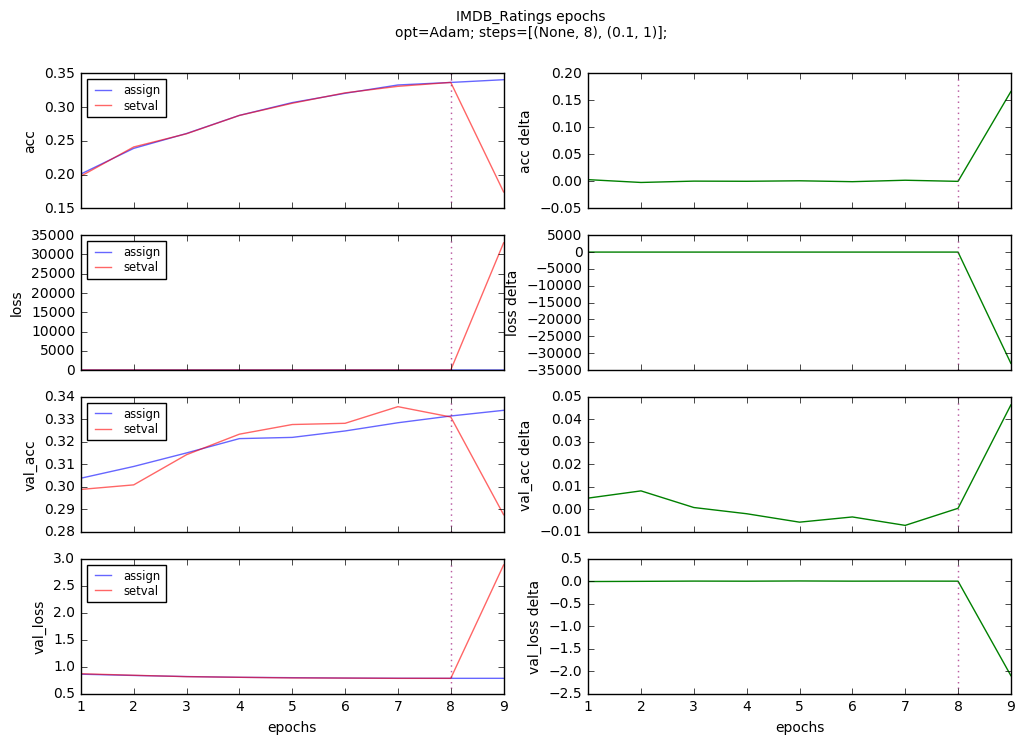

In [58]:
LRTester(IMDB_Ratings, shuffle=True).run(steps=[(None, 8), 0.1]).makefigs()

### GPU Results: IMDB Ratings NN (No Dropout)

**Running IMDB_Ratings_NoDropout with opt=Adam, setter=assign, steps=[(None, 8), (0.1, 1)]**

Train on 79753 samples, validate on 20251 samples
Epoch 1/8
79753/79753 [==============================] - 7s - loss: 1.7502 - acc: 0.2610 - val_loss: 1.3692 - val_acc: 0.2706
Epoch 2/8
79753/79753 [==============================] - 7s - loss: 0.8581 - acc: 0.3202 - val_loss: 1.0630 - val_acc: 0.3105
Epoch 3/8
79753/79753 [==============================] - 7s - loss: 0.7944 - acc: 0.3342 - val_loss: 0.9084 - val_acc: 0.3126
Epoch 4/8
79753/79753 [==============================] - 7s - loss: 0.7621 - acc: 0.3457 - val_loss: 0.8955 - val_acc: 0.3055
Epoch 5/8
79753/79753 [==============================] - 7s - loss: 0.7291 - acc: 0.3575 - val_loss: 1.0128 - val_acc: 0.3026
Epoch 6/8
79753/79753 [==============================] - 7s - loss: 0.7094 - acc: 0.3670 - val_loss: 1.0102 - val_acc: 0.3057
Epoch 7/8
79753/79753 [==============================] - 7s - loss: 0.6991 - acc: 0.3706 - val_loss: 0.9260 - val_acc: 0.3138
Epoch 8/8
79753/79753 [==============================] - 7s - loss: 

**Running IMDB_Ratings_NoDropout with opt=Adam, setter=setval, steps=[(None, 8), (0.1, 1)]**

Train on 79753 samples, validate on 20251 samples
Epoch 1/8
79753/79753 [==============================] - 7s - loss: 1.7502 - acc: 0.2610 - val_loss: 1.3692 - val_acc: 0.2706
Epoch 2/8
79753/79753 [==============================] - 7s - loss: 0.8581 - acc: 0.3202 - val_loss: 1.0630 - val_acc: 0.3105
Epoch 3/8
79753/79753 [==============================] - 7s - loss: 0.7944 - acc: 0.3342 - val_loss: 0.9084 - val_acc: 0.3126
Epoch 4/8
79753/79753 [==============================] - 7s - loss: 0.7621 - acc: 0.3457 - val_loss: 0.8955 - val_acc: 0.3055
Epoch 5/8
79753/79753 [==============================] - 7s - loss: 0.7291 - acc: 0.3575 - val_loss: 1.0128 - val_acc: 0.3026
Epoch 6/8
79753/79753 [==============================] - 7s - loss: 0.7094 - acc: 0.3670 - val_loss: 1.0101 - val_acc: 0.3057
Epoch 7/8
79753/79753 [==============================] - 7s - loss: 0.6991 - acc: 0.3704 - val_loss: 0.9256 - val_acc: 0.3138
Epoch 8/8
79753/79753 [==============================] - 7s - loss: 

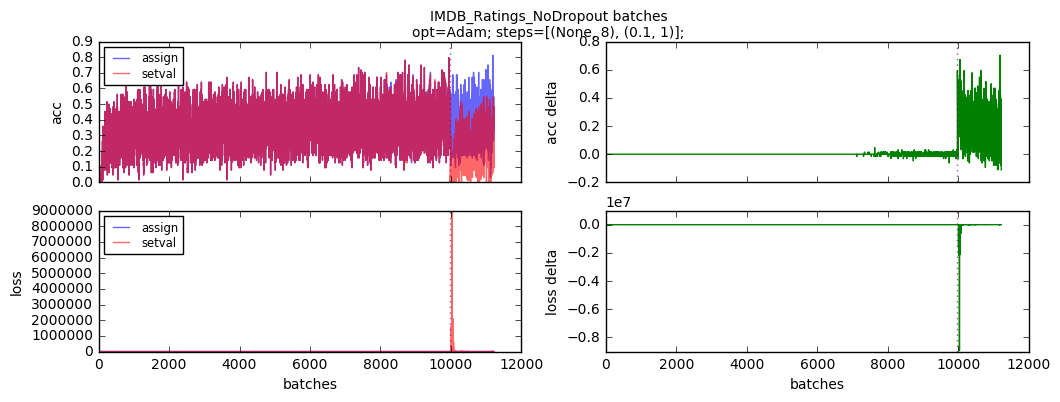

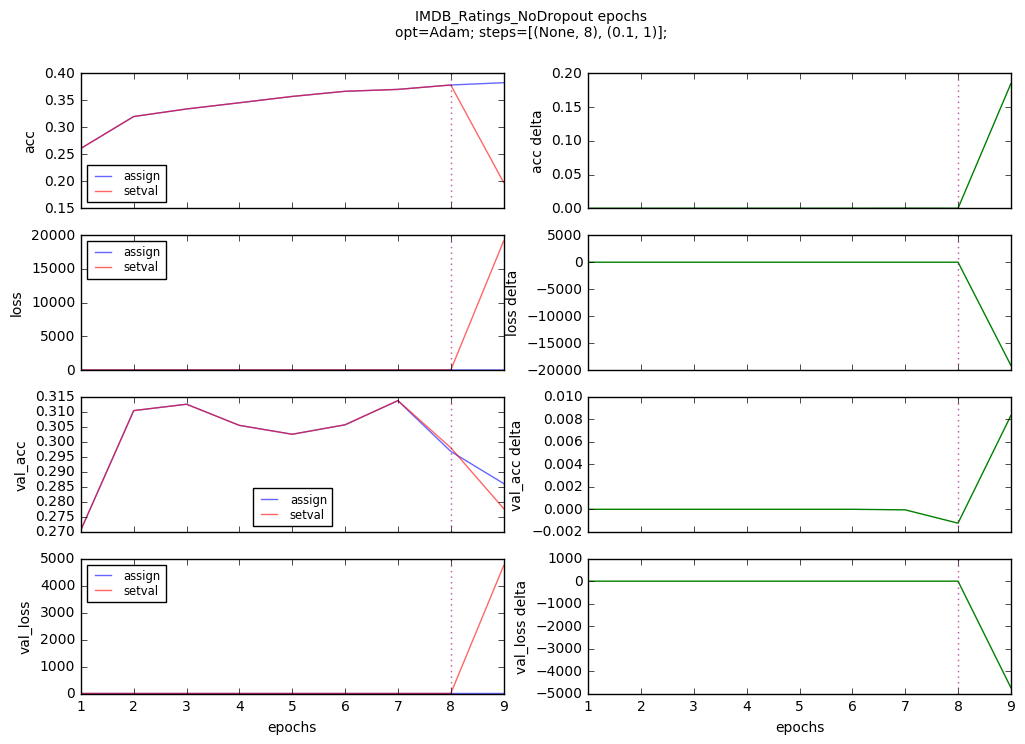

In [59]:
LRTester(IMDB_Ratings_NoDropout, shuffle=False).run(steps=[(None, 8), 0.1]).makefigs()

### GPU Results: IMDB Sentiment Analysis CNN

**Running IMDB_Sentiment_Analysis with opt=Adam, setter=assign, steps=[(None, 2), (0.0001, 1)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 12s - loss: 0.6171 - acc: 0.6446 - val_loss: 0.5396 - val_acc: 0.7227
Epoch 2/2
25000/25000 [==============================] - 12s - loss: 0.5081 - acc: 0.7589 - val_loss: 0.4572 - val_acc: 0.8092
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 12s - loss: 0.4728 - acc: 0.7784 - val_loss: 0.4338 - val_acc: 0.8148


**Running IMDB_Sentiment_Analysis with opt=Adam, setter=setval, steps=[(None, 2), (0.0001, 1)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 12s - loss: 0.6225 - acc: 0.6454 - val_loss: 0.5240 - val_acc: 0.7619
Epoch 2/2
25000/25000 [==============================] - 12s - loss: 0.5088 - acc: 0.7580 - val_loss: 0.4556 - val_acc: 0.7998
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 12s - loss: 0.4741 - acc: 0.7840 - val_loss: 0.4489 - val_acc: 0.8117


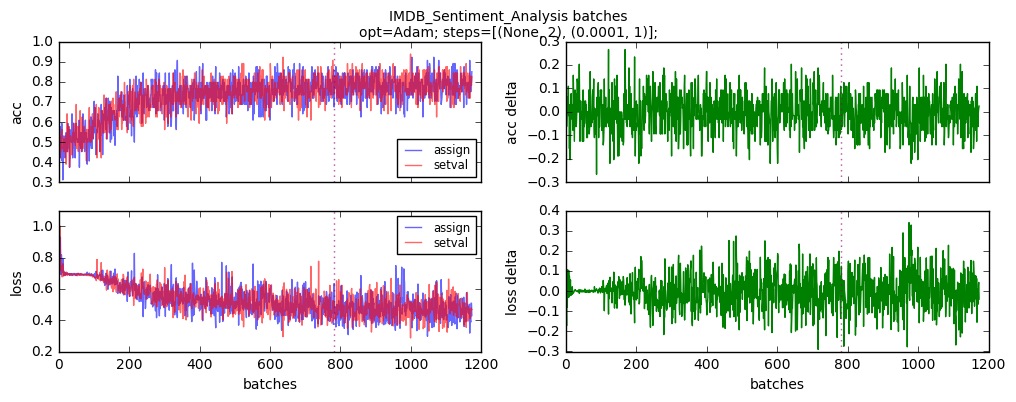

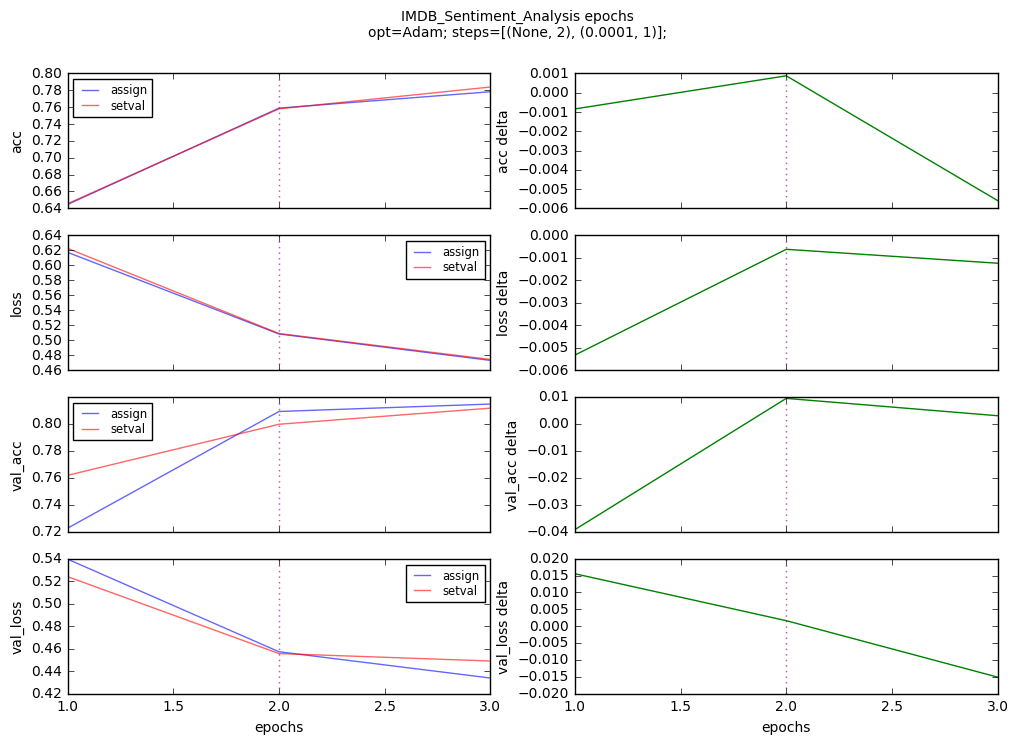

In [60]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=True)
t = LRTester(IMDB_Sentiment_Analysis, shuffle=True)
t.run(steps=[(None, 2), 1e-4], step_callback=step_callback)
t.makefigs()

### GPU Results: IMDB Sentiment Analysis CNN (No Dropout)

**Running IMDB_Sentiment_Analysis_NoDropout with opt=Adam, setter=assign, steps=[(None, 2), (0.0001, 1)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 9s - loss: 0.5172 - acc: 0.7350 - val_loss: 0.4482 - val_acc: 0.7922
Epoch 2/2
25000/25000 [==============================] - 9s - loss: 0.3736 - acc: 0.8343 - val_loss: 0.3805 - val_acc: 0.8298
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 9s - loss: 0.2954 - acc: 0.8752 - val_loss: 0.4393 - val_acc: 0.8107


**Running IMDB_Sentiment_Analysis_NoDropout with opt=Adam, setter=setval, steps=[(None, 2), (0.0001, 1)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 9s - loss: 0.5283 - acc: 0.7229 - val_loss: 0.4239 - val_acc: 0.8044
Epoch 2/2
25000/25000 [==============================] - 9s - loss: 0.3736 - acc: 0.8336 - val_loss: 0.3797 - val_acc: 0.8288
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 9s - loss: 0.2693 - acc: 0.8919 - val_loss: 0.3867 - val_acc: 0.8293


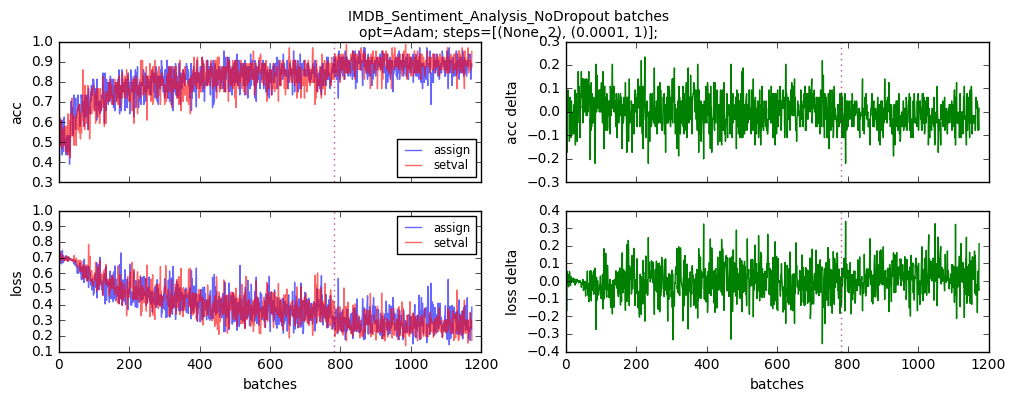

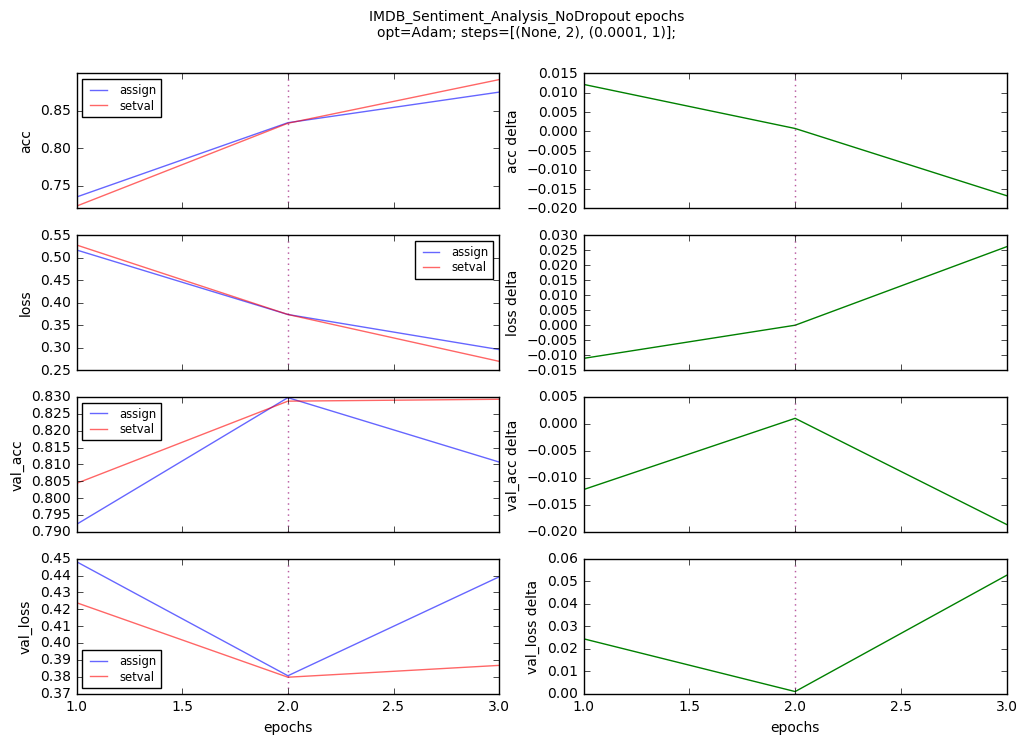

In [61]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=True)
t = LRTester(IMDB_Sentiment_Analysis_NoDropout, shuffle=True)
t.run(steps=[(None, 2), 1e-4], step_callback=step_callback)
t.makefigs()

### GPU Results: IMDB Sentiment Analysis Multi CNN

**Running IMDB_Sentiment_Analysis_Multi_CNN with opt=Adam, setter=assign, steps=[(None, 2), (1e-05, 2)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s - loss: 0.5532 - acc: 0.6894 - val_loss: 0.3044 - val_acc: 0.8749
Epoch 2/2
25000/25000 [==============================] - 30s - loss: 0.3338 - acc: 0.8675 - val_loss: 0.2671 - val_acc: 0.8922
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s - loss: 0.2870 - acc: 0.8857 - val_loss: 0.2778 - val_acc: 0.8853
Epoch 2/2
25000/25000 [==============================] - 30s - loss: 0.2633 - acc: 0.8958 - val_loss: 0.2543 - val_acc: 0.8980


**Running IMDB_Sentiment_Analysis_Multi_CNN with opt=Adam, setter=setval, steps=[(None, 2), (1e-05, 2)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s - loss: 0.5424 - acc: 0.7058 - val_loss: 0.3325 - val_acc: 0.8638
Epoch 2/2
25000/25000 [==============================] - 30s - loss: 0.3258 - acc: 0.8681 - val_loss: 0.2756 - val_acc: 0.8894
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s - loss: 0.2863 - acc: 0.8854 - val_loss: 0.2660 - val_acc: 0.8942
Epoch 2/2
25000/25000 [==============================] - 30s - loss: 0.2824 - acc: 0.8900 - val_loss: 0.2631 - val_acc: 0.8953


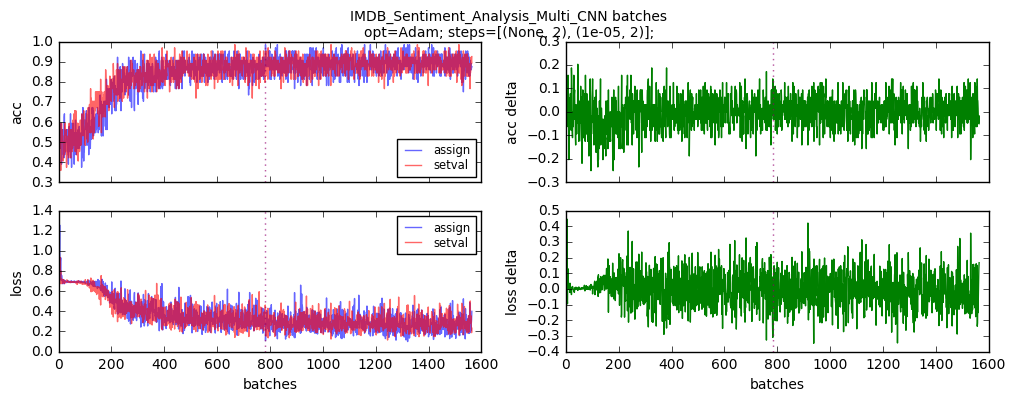

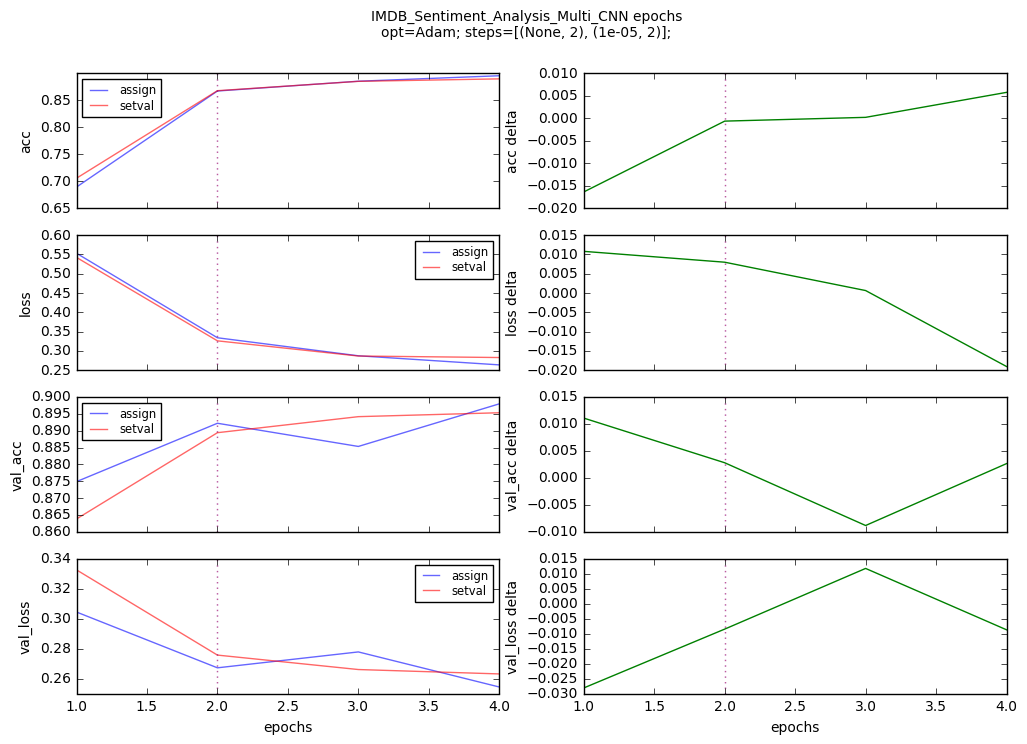

In [62]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=False)
t = LRTester(IMDB_Sentiment_Analysis_Multi_CNN, shuffle=True)
t.run(steps=[(None, 2), (1e-5, 2)], step_callback=step_callback)
t.makefigs()

### GPU Results: IMDB Sentiment Analysis Multi CNN (No Dropout)

**Running IMDB_Sentiment_Analysis_Multi_CNN_NoDropout with opt=Adam, setter=assign, steps=[(None, 2), (1e-05, 2)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 27s - loss: 0.4347 - acc: 0.7767 - val_loss: 0.2724 - val_acc: 0.8871
Epoch 2/2
25000/25000 [==============================] - 27s - loss: 0.2184 - acc: 0.9143 - val_loss: 0.2873 - val_acc: 0.8846
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 27s - loss: 0.1505 - acc: 0.9446 - val_loss: 0.2766 - val_acc: 0.8901
Epoch 2/2
25000/25000 [==============================] - 27s - loss: 0.0890 - acc: 0.9718 - val_loss: 0.3315 - val_acc: 0.8809


**Running IMDB_Sentiment_Analysis_Multi_CNN_NoDropout with opt=Adam, setter=setval, steps=[(None, 2), (1e-05, 2)]**

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 27s - loss: 0.4601 - acc: 0.7419 - val_loss: 0.2735 - val_acc: 0.8852
Epoch 2/2
25000/25000 [==============================] - 27s - loss: 0.2199 - acc: 0.9149 - val_loss: 0.2764 - val_acc: 0.8862
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 27s - loss: 0.1319 - acc: 0.9572 - val_loss: 0.2582 - val_acc: 0.8944
Epoch 2/2
25000/25000 [==============================] - 27s - loss: 0.1251 - acc: 0.9590 - val_loss: 0.2600 - val_acc: 0.8943


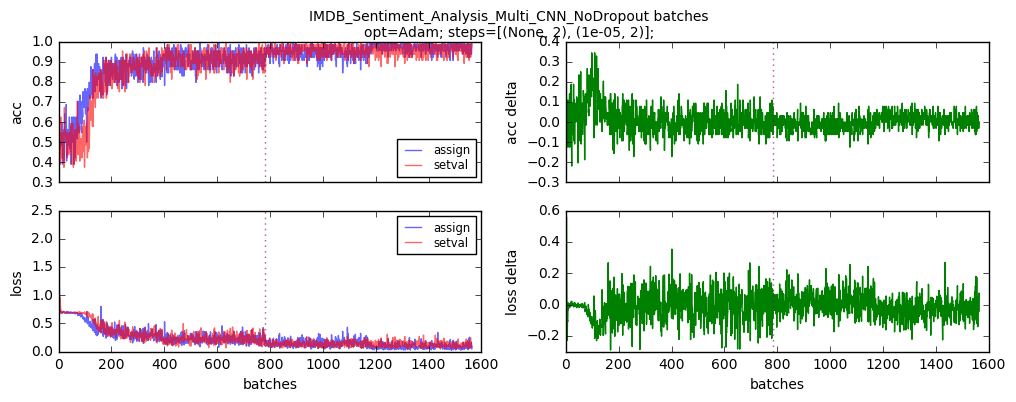

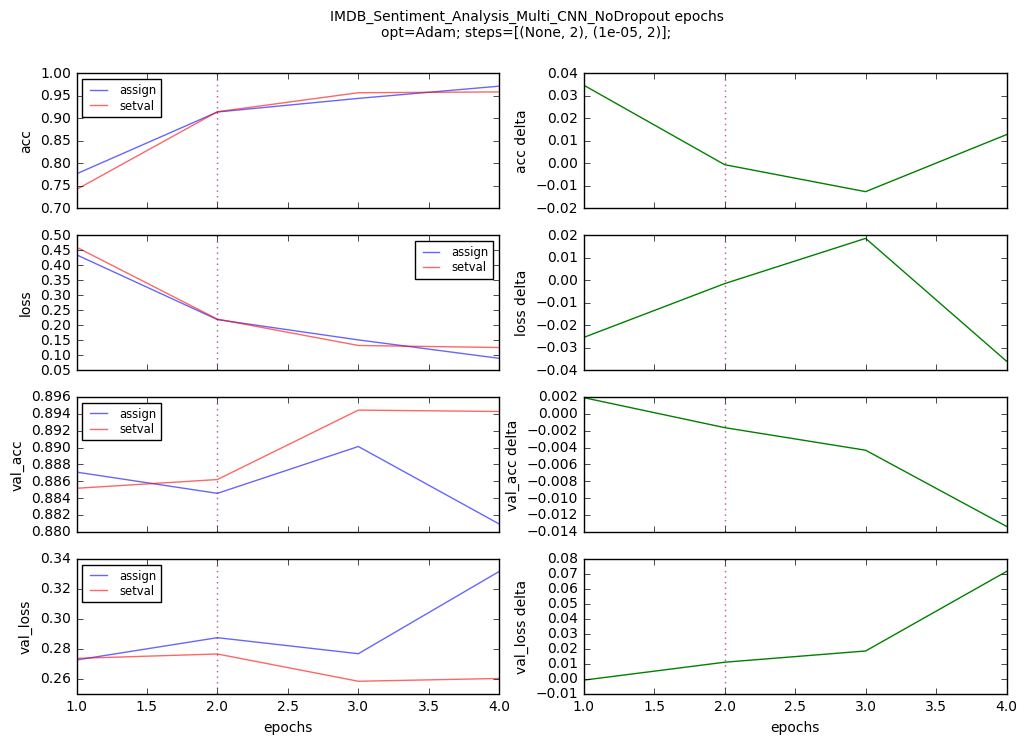

In [63]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=False)
t = LRTester(IMDB_Sentiment_Analysis_Multi_CNN_NoDropout, shuffle=True)
t.run(steps=[(None, 2), (1e-5, 2)], step_callback=step_callback)
t.makefigs()

### GPU Results: Nietzsche 3-char model

**Running Nietzsche_3Char with opt=Adam, setter=assign, steps=[(1e-06, 4), (0.01, 4), (1e-06, 4), (0.01, 4)]**

Epoch 1/4
200297/200297 [==============================] - 16s - loss: 4.4246 - acc: 0.0737    
Epoch 2/4
200297/200297 [==============================] - 16s - loss: 4.3113 - acc: 0.1526    
Epoch 3/4
200297/200297 [==============================] - 16s - loss: 4.0715 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 16s - loss: 3.6927 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 15s - loss: 3.3543 - acc: 0.1524    
Epoch 2/4
200297/200297 [==============================] - 16s - loss: 3.2064 - acc: 0.1524    
Epoch 3/4
200297/200297 [==============================] - 15s - loss: 3.1508 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 16s - loss: 3.1242 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 16s - loss: 3.1077 - acc: 0.1524    
Epoch 2/4
200297/200297 [==============================] - 16s - loss: 3.0958 - acc: 0.1524    
Epoch 3/4
200297/200297 [===============

**Running Nietzsche_3Char with opt=Adam, setter=setval, steps=[(1e-06, 4), (0.01, 4), (1e-06, 4), (0.01, 4)]**

Epoch 1/4
200297/200297 [==============================] - 16s - loss: 4.4246 - acc: 0.0736    
Epoch 2/4
200297/200297 [==============================] - 16s - loss: 4.3113 - acc: 0.1526    
Epoch 3/4
200297/200297 [==============================] - 16s - loss: 4.0715 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 16s - loss: 3.6921 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 16s - loss: 5.9567 - acc: 0.2316    
Epoch 2/4
200297/200297 [==============================] - 16s - loss: 5.7433 - acc: 0.2431    
Epoch 3/4
200297/200297 [==============================] - 16s - loss: 5.0769 - acc: 0.2529    
Epoch 4/4
200297/200297 [==============================] - 16s - loss: 4.4020 - acc: 0.2604    
Epoch 1/4
200297/200297 [==============================] - 16s - loss: 4.3436 - acc: 0.2728    
Epoch 2/4
200297/200297 [==============================] - 16s - loss: 4.3021 - acc: 0.2707    
Epoch 3/4
200297/200297 [===============

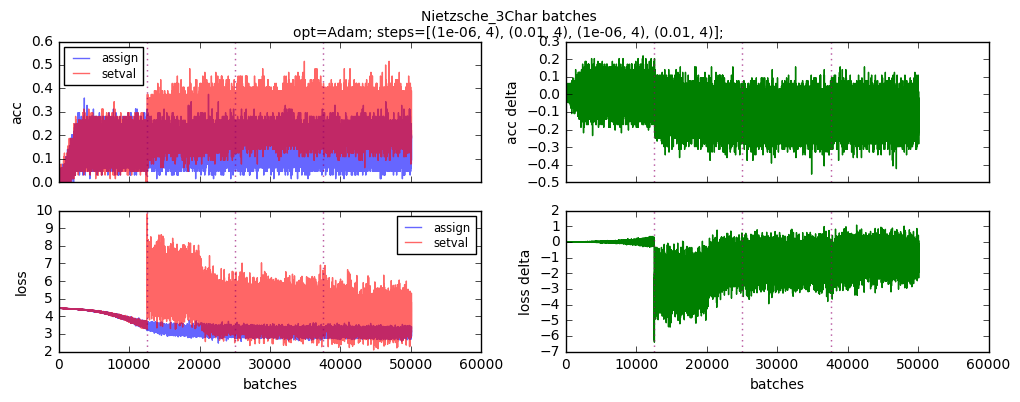

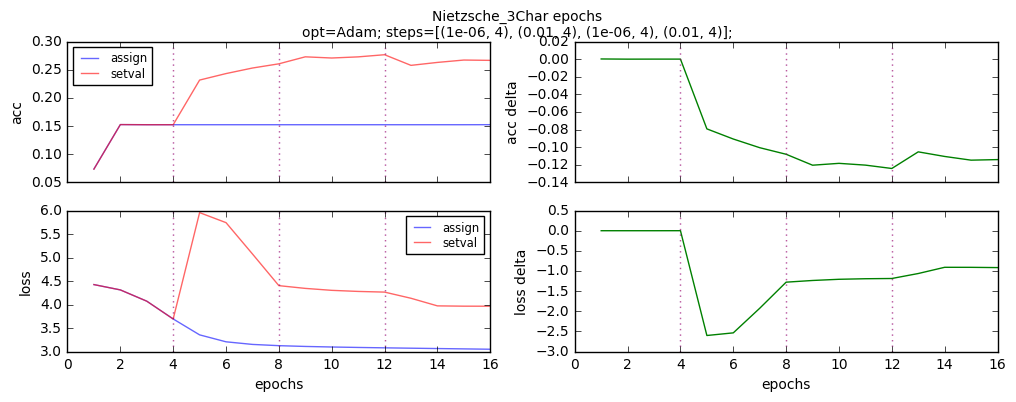

In [64]:
LRTester(Nietzsche_3Char, shuffle=True).run(steps=[(0.000001, 4), (0.01, 4), (0.000001, 4), (0.01, 4)]).makefigs()

In [66]:
t = Out[64]

In [67]:
nietzsche_compare_3char(t.models[0], t.models[1], inputs=['phi', ' th', ' an'])

[(' ', 't'), (' ', 'e'), (' ', 'd')]

### GPU Results: Nietzsche RNN returing sequences

As with `DogsCats_Vgg16_NoDropout` and `IMDB_Ratings`, above, add a single learning rate change after the 8 initial epochs, to make the test more interesting.

**Running Nietzsche_RNN_Keras_Sequences with opt=Adam, setter=assign, steps=[(None, 8), (0.1, 1)]**

Epoch 1/8
75110/75110 [==============================] - 14s - loss: 2.4330 - acc: 0.3158    
Epoch 2/8
75110/75110 [==============================] - 14s - loss: 2.0090 - acc: 0.4118    
Epoch 3/8
75110/75110 [==============================] - 13s - loss: 1.8909 - acc: 0.4411    
Epoch 4/8
75110/75110 [==============================] - 14s - loss: 1.8282 - acc: 0.4564    
Epoch 5/8
75110/75110 [==============================] - 13s - loss: 1.7886 - acc: 0.4668    
Epoch 6/8
75110/75110 [==============================] - 14s - loss: 1.7616 - acc: 0.4732    
Epoch 7/8
75110/75110 [==============================] - 13s - loss: 1.7412 - acc: 0.4782    
Epoch 8/8
75110/75110 [==============================] - 13s - loss: 1.7251 - acc: 0.4824    
Epoch 1/1
75110/75110 [==============================] - 13s - loss: 1.7123 - acc: 0.4853    


**Running Nietzsche_RNN_Keras_Sequences with opt=Adam, setter=setval, steps=[(None, 8), (0.1, 1)]**

Epoch 1/8
75110/75110 [==============================] - 14s - loss: 2.4293 - acc: 0.3161    
Epoch 2/8
75110/75110 [==============================] - 14s - loss: 2.0052 - acc: 0.4124    
Epoch 3/8
75110/75110 [==============================] - 14s - loss: 1.8876 - acc: 0.4425    
Epoch 4/8
75110/75110 [==============================] - 14s - loss: 1.8254 - acc: 0.4575    
Epoch 5/8
75110/75110 [==============================] - 14s - loss: 1.7862 - acc: 0.4672    
Epoch 6/8
75110/75110 [==============================] - 14s - loss: 1.7588 - acc: 0.4739    
Epoch 7/8
75110/75110 [==============================] - 14s - loss: 1.7379 - acc: 0.4790    
Epoch 8/8
75110/75110 [==============================] - 14s - loss: 1.7216 - acc: 0.4830    
Epoch 1/1
75110/75110 [==============================] - 14s - loss: 3.5343 - acc: 0.1486    


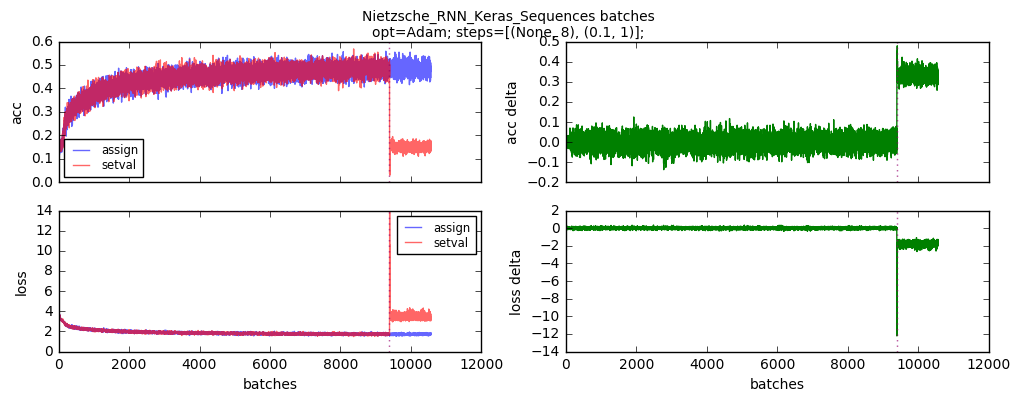

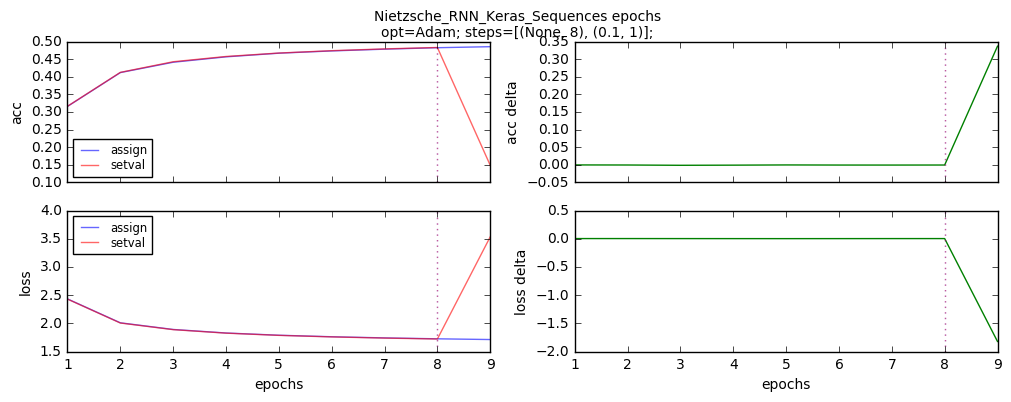

In [65]:
LRTester(Nietzsche_RNN_Keras_Sequences, shuffle=True).run(steps=[(None, 8), 0.1]).makefigs()

In [68]:
t = Out[65]

In [69]:
nietzsche_get_nexts_keras(t.models[0], ' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


['t', 'h', 'e', 's', ' ', 'a', 's', ' ']

In [70]:
nietzsche_get_nexts_keras(t.models[1], ' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

## GPU Results: go crazy

The test resutls in this "go crazy" section correspond to two calls to the `gocrazy` function, each of which tests a cross-product of it's arguments:

    Models x Setters x Optimizers x Steps1 x Steps2

In [72]:
def gocrazy(models, setters=None, optimizers=None, steps1=None, steps2=None,
            batch_size=64, shuffle=False, verbose=1):
    "Generate graphs for the cross-prodcut of models x setters x optimizers x steps1 x steps2."
    setters = setters or [AssignAndSetVal, BothAssign, BothSetVal]
    optimizers = optimizers or [Adam, SGD, RMSprop]
    steps1 = steps1 or [[0.0001, 0.1]]
    steps2 = steps2 or steps1
    
    # Allow optimizers=Adam as shorthand for optimizers=[Adam], etc.
    def ensure_iter(x):
        return x if hasattr(x, '__iter__') else [x]
    
    models = ensure_iter(models)
    setters = ensure_iter(setters)
    optimizers = ensure_iter(optimizers)
    
    for model in models:
        for setter in setters:
            for opt in optimizers:
                t = LRTester(model, setter=setter, optimizer=opt, batch_size=batch_size,
                             shuffle=shuffle, verbose=verbose)
                for step1 in steps1:
                    t.reset('first')
                    t.run(which='first', steps1=step1)
                    for step2 in steps2:
                        t.reset('second')
                        t.run(which='second', steps2=step2)
                        t.makefigs()
            

The first call to `gocrazy` looks at a small subset of models, and asks the question: how do the models behave when both use assignment (`BothAssign`) or both use `set_value` (`BothSetVal`), but the learning rates for the two models are stepped differently? That is, when `steps1 != steps2`. Specifically:

    Models = [MNIST_CNN_BN_NoDropout_NoDataAug, IMDB_Ratings_NoDropout, Nietzsche_3Char]
    Setters = [BothAssign, BothSetVal]
    Opitimizers = [Adam, SGD]
    Steps1 = [[0.0001, 0.0001]]
    Steps2 = [[0.0001, 0.1], [0.1, 0.0001]]

In the second call to `gocrazy`, we do a more exhaustive test for a single model:

    Models = [MNIST_Linear]
    Setters = [AssignAndSetVal, BothAssign, BothSetVal]
    Opitimizers = [Adam, SGD, RMSprop]
    Steps1 = [[0.1, 0.0001], [0.0001, 0.1]]
    Steps2 = [[0.1, 0.0001], [0.0001, 0.1]]

## CPU Results

This section contains results for whatever random tests I happened to run on my laptop CPU while I was testing things out. The **GPU Results** section above has more structured tests.

### CPU Results: MNIST Linear Model

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4368 - acc: 0.8711 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3115 - acc: 0.9114 - val_loss: 0.3076 - val_acc: 0.9097
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.2966 - acc: 0.9168 - val_loss: 0.3046 - val_acc: 0.9116
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4368 - acc: 0.8711 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 5.0220 - acc: 0.6768 - val_loss: 4.4106 - val_acc: 0.7194
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.2451 - acc: 0.7308 - val_loss: 4.0815 - val_acc: 0.7414


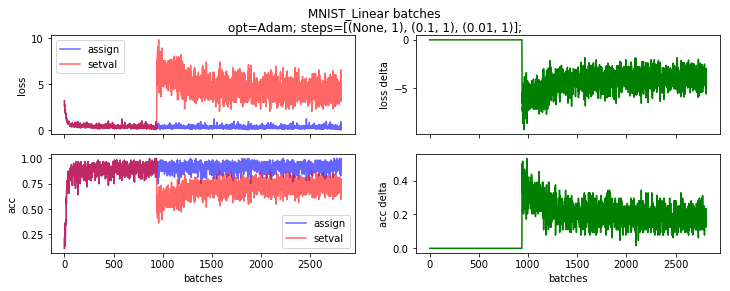

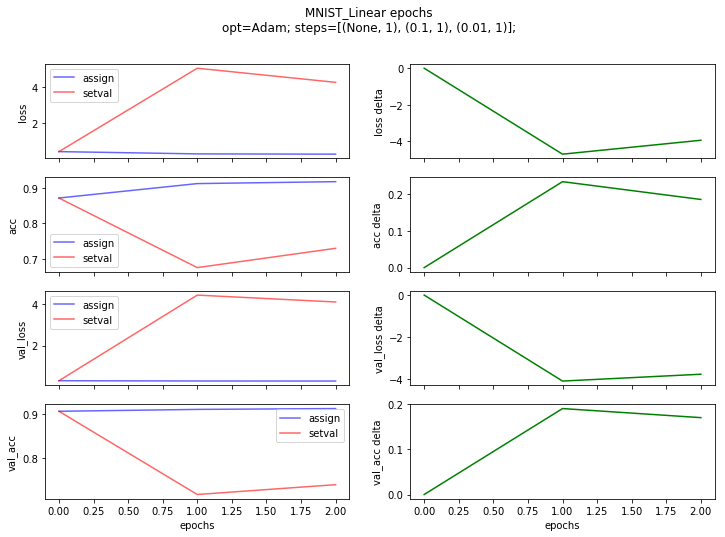

In [22]:
LRTester(MNIST_Linear).run(steps=[None, 0.1, 0.01]).makefigs()

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3100 - acc: 0.9122 - val_loss: 0.3082 - val_acc: 0.9111
Epoch 1/4
60000/60000 [==============================] - 24s - loss: 0.2959 - acc: 0.9172 - val_loss: 0.3052 - val_acc: 0.9124
Epoch 2/4
60000/60000 [==============================] - 24s - loss: 0.2884 - acc: 0.9197 - val_loss: 0.3041 - val_acc: 0.9136
Epoch 3/4
60000/60000 [==============================] - 24s - loss: 0.2833 - acc: 0.9212 - val_loss: 0.3033 - val_acc: 0.9138
Epoch 4/4
60000/60000 [==============================] - 30s - loss: 0.2796 - acc: 0.9226 - val_loss: 0.3031 - val_acc: 0.9147
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.4333 - acc: 0.8726 - val_loss: 0.3210 - val_acc: 0.9059
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 6.8714 - acc: 0.5677 - val_loss: 6.5073 - 

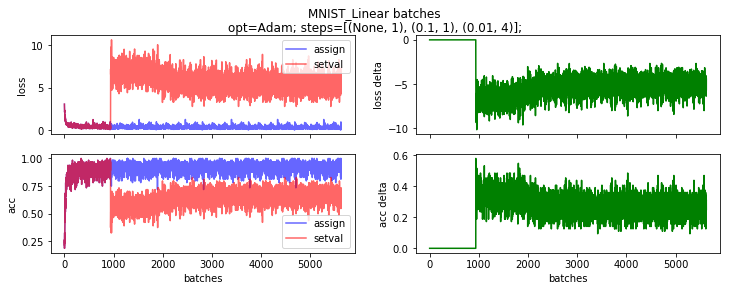

In [455]:
t = LRTester(MNIST_Linear, setter=AssignAndSetVal, optimizer=Adam)
t.run(steps=[(None, 1), (0.1, 1), (0.01, 4)])
t.makefig('batches')

Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.4305 - acc: 0.8727 - val_loss: 0.3216 - val_acc: 0.9039
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.3099 - acc: 0.9116 - val_loss: 0.3102 - val_acc: 0.9097
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 0.4305 - acc: 0.8727 - val_loss: 0.3216 - val_acc: 0.9039
Epoch 1/1
60000/60000 [==============================] - 27s - loss: 0.3099 - acc: 0.9116 - val_loss: 0.3102 - val_acc: 0.9097


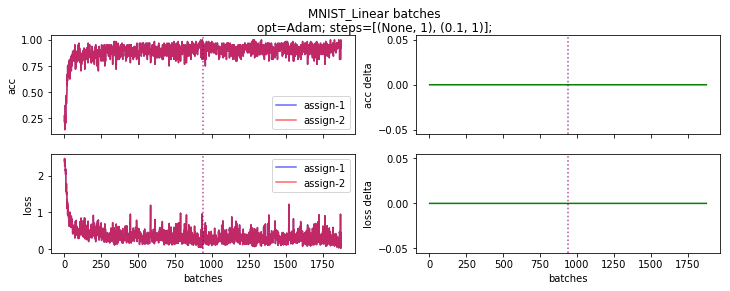

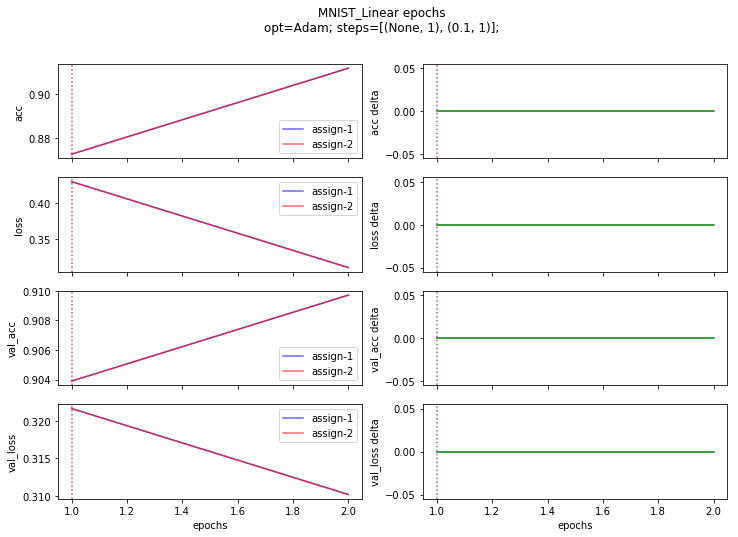

In [71]:
LRTester(MNIST_Linear, setter=BothAssign).run(steps=[None, 0.1]).makefigs()

Epoch 1/1
60000/60000 [==============================] - 23s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 24s - loss: 0.3110 - acc: 0.9113 - val_loss: 0.3083 - val_acc: 0.9110
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.2966 - acc: 0.9167 - val_loss: 0.3055 - val_acc: 0.9129
Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.4359 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.9073
Epoch 1/1
60000/60000 [==============================] - 26s - loss: 4.7737 - acc: 0.6910 - val_loss: 4.6670 - val_acc: 0.7028
Epoch 1/1
60000/60000 [==============================] - 34s - loss: 4.2944 - acc: 0.7280 - val_loss: 4.1933 - val_acc: 0.7346


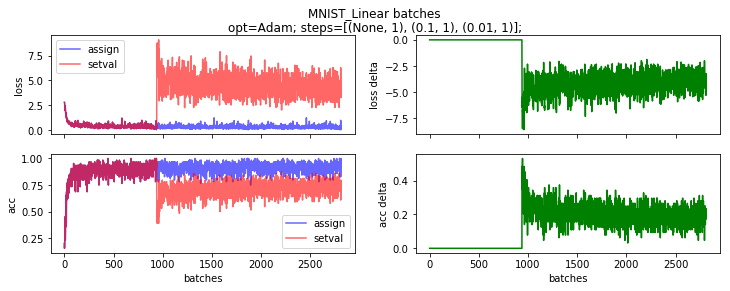

Epoch 1/1
60000/60000 [==============================] - 31s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 33s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698
Epoch 1/1
60000/60000 [==============================] - 29s - loss: 0.4367 - acc: 0.8693 - val_loss: 0.3218 - val_acc: 0.9043
Epoch 1/1
60000/60000 [==============================] - 22s - loss: 5.7198 - acc: 0.6361 - val_loss: 5.4093 - val_acc: 0.6606.63 - ETA: 1s - l - ETA: 0s - loss: 5.7354 -  - ETA: 0s - los
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 5.3876 - acc: 0.6621 - val_loss: 5.2668 - val_acc: 0.6698


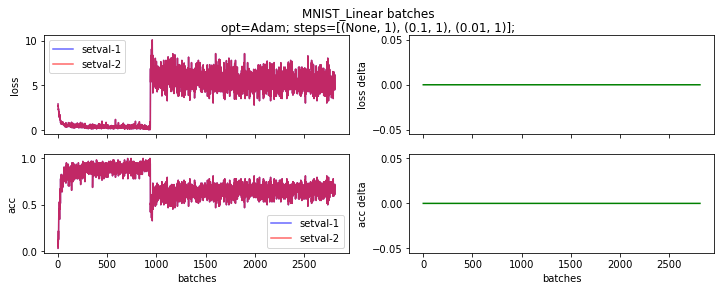

Epoch 1/1
60000/60000 [==============================] - 34s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.4336 - acc: 0.8712 - val_loss: 0.3202 - val_acc: 0.9075
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.3115 - acc: 0.9111 - val_loss: 0.3076 - val_acc: 0.9100
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.2967 - acc: 0.9162 - val_loss: 0.3043 - val_acc: 0.9115


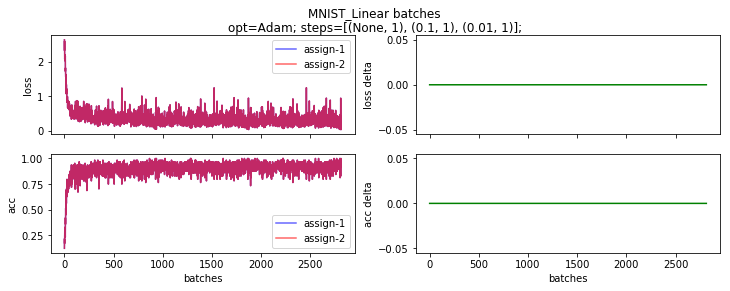

Epoch 1/1
60000/60000 [==============================] - 41s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.90110.5072 - acc: 0.85
Epoch 1/1
60000/60000 [==============================] - 32s - loss: 0.3425 - acc: 0.9017 - val_loss: 0.3132 - val_acc: 0.9102
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3184 - acc: 0.9088 - val_loss: 0.3004 - val_acc: 0.9135
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.5069 - acc: 0.8510 - val_loss: 0.3448 - val_acc: 0.9011
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.3429 - acc: 0.9024 - val_loss: 0.3415 - val_acc: 0.9010
Epoch 1/1
60000/60000 [==============================] - 40s - loss: 0.2857 - acc: 0.9208 - val_loss: 0.2807 - val_acc: 0.9207


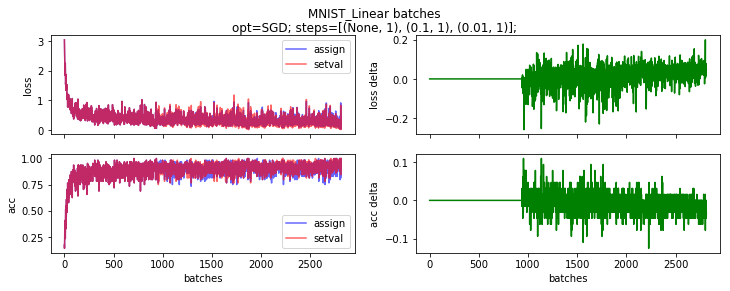

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200.920 - ETA: 0s - loss: 0.
Epoch 1/1
60000/60000 [==============================] - 37s - loss: 0.5187 - acc: 0.8493 - val_loss: 0.3436 - val_acc: 0.9004
Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.3429 - acc: 0.9022 - val_loss: 0.3418 - val_acc: 0.9033
Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.2861 - acc: 0.9209 - val_loss: 0.2804 - val_acc: 0.9200


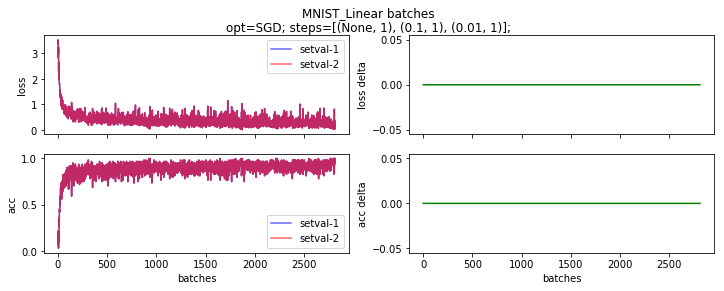

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 35s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120
Epoch 1/1
60000/60000 [==============================] - 36s - loss: 0.5028 - acc: 0.8519 - val_loss: 0.3484 - val_acc: 0.8997
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3413 - acc: 0.9019 - val_loss: 0.3158 - val_acc: 0.9079
Epoch 1/1
60000/60000 [==============================] - 43s - loss: 0.3176 - acc: 0.9089 - val_loss: 0.3026 - val_acc: 0.9120


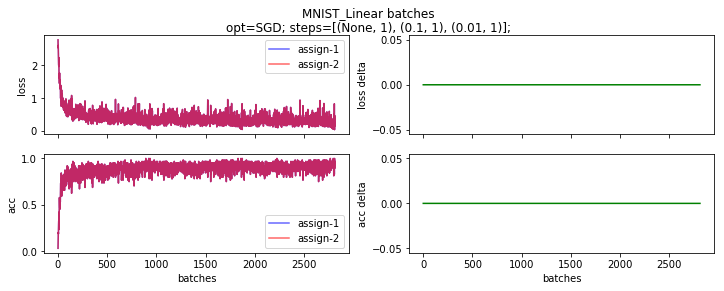

In [458]:
runtests(MNIST_Linear)

### CPU Results: MNIST CNN with batchnorm + dropout + data augmentation

/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ma/opt/anaconda3/envs/fastai/lib/python2.7/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


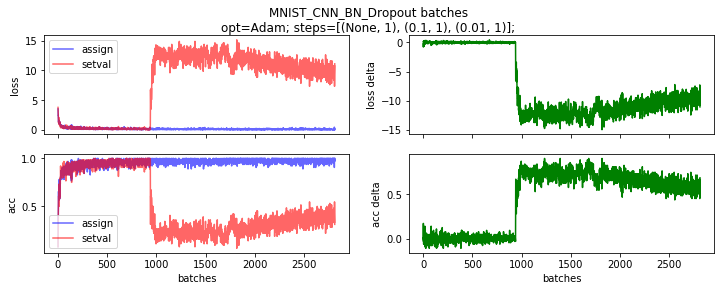

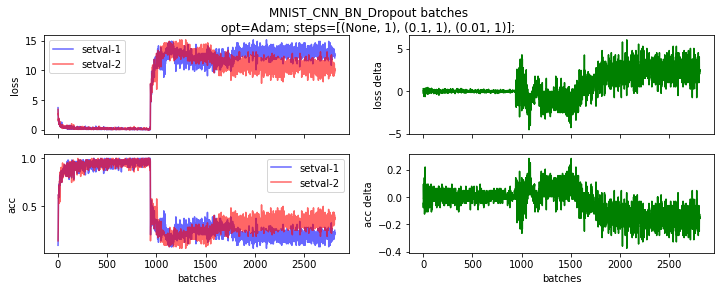

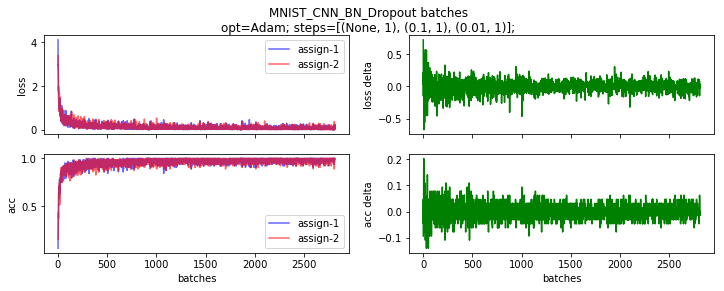

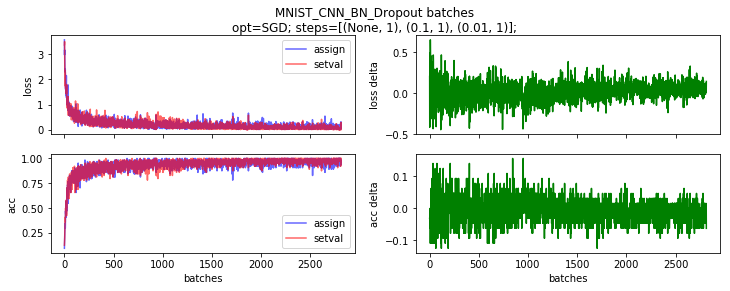

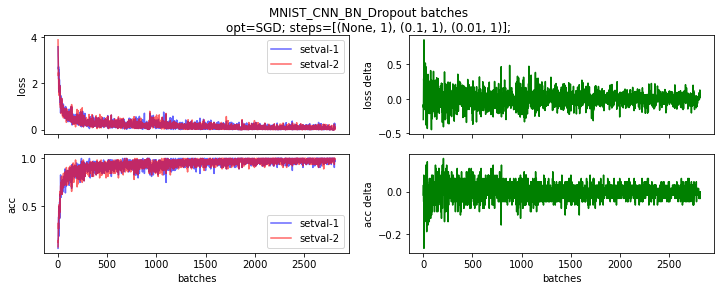

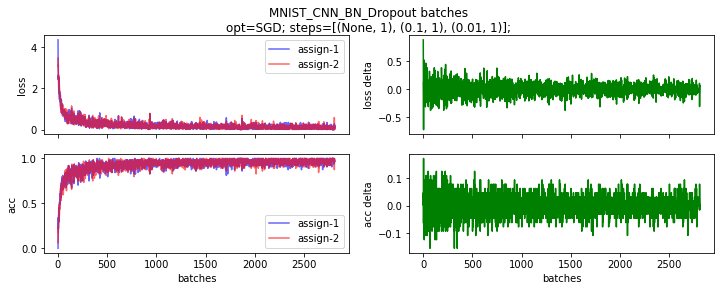

In [464]:
runtests(MNIST_CNN_BN)

### CPU Results: MNIST CNN with batchnorm, no dropout, no data augmentation

Epoch 1/1
60000/60000 [==============================] - 520s - loss: 0.0883 - acc: 0.9736 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 1/1
60000/60000 [==============================] - 603s - loss: 0.0295 - acc: 0.9905 - val_loss: 0.0365 - val_acc: 0.9892
Epoch 1/1
60000/60000 [==============================] - 623s - loss: 0.0883 - acc: 0.9736 - val_loss: 0.0506 - val_acc: 0.9833
Epoch 1/1
60000/60000 [==============================] - 621s - loss: 11.1748 - acc: 0.3048 - val_loss: 10.9154 - val_acc: 0.3224


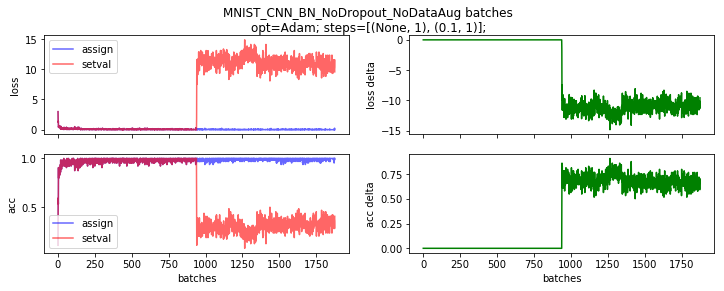

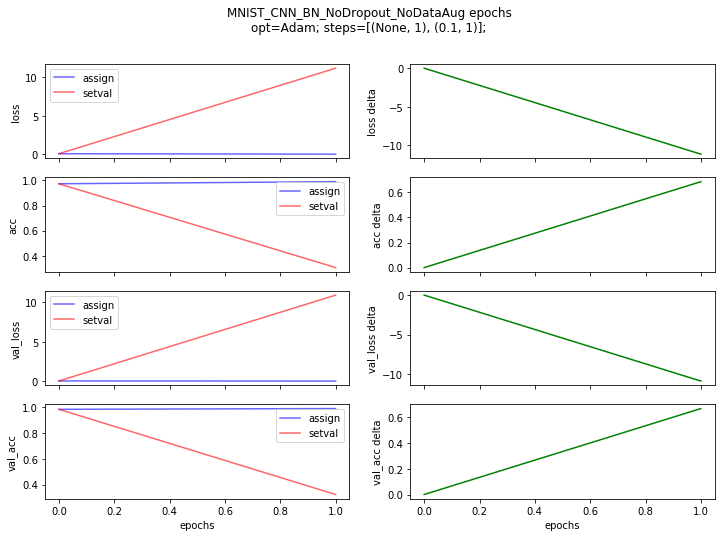

In [40]:
LRTester(MNIST_CNN_BN_NoDropout_NoDataAug).run([None, 0.1]).makefigs()

### CPU Results: DogsCats Vgg16

### CPU Results: DogsCats Vgg16 No Dropout

### CPU Results: IMDB Ratings NN

Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 29s - loss: 2.5930 - acc: 0.1850 - val_loss: 1.2576 - val_acc: 0.2752
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 50s - loss: 1.5564 - acc: 0.2285 - val_loss: 0.8845 - val_acc: 0.3137
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 39s - loss: 1.2877 - acc: 0.2511 - val_loss: 0.8813 - val_acc: 0.2950
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 32s - loss: 2.6022 - acc: 0.1836 - val_loss: 1.2231 - val_acc: 0.2827
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 38s - loss: 6281.3644 - acc: 0.1915 - val_loss: 9091.3288 - val_acc: 0.2884
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 84

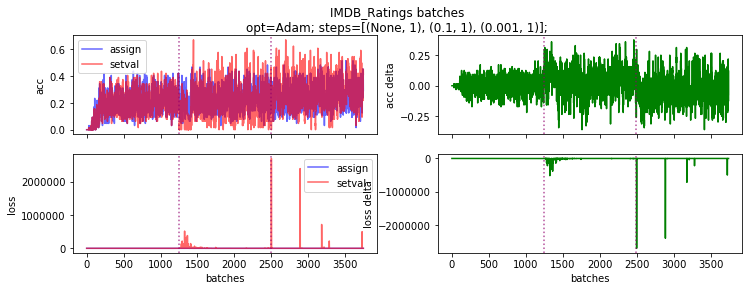

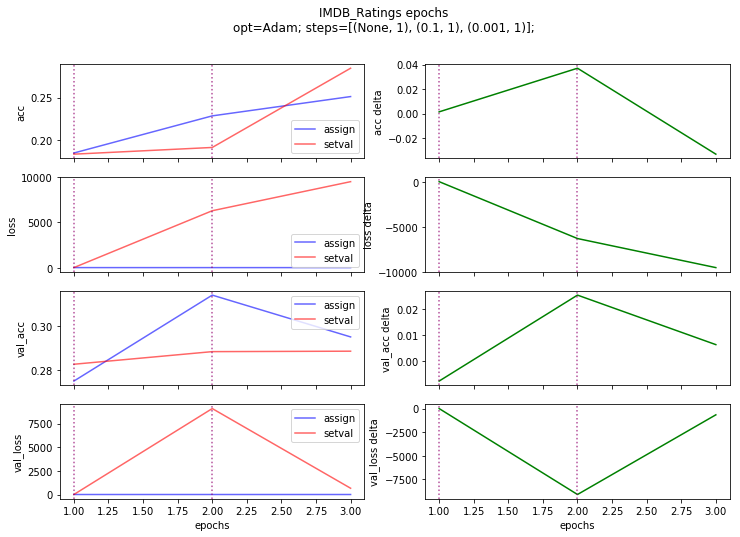

In [117]:
LRTester(IMDB_Ratings).run(steps=[None, 0.1, 0.001]).makefigs()

### CPU Results: IMDB Ratings NN (No Dropout)

Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 25s - loss: 1.7542 - acc: 0.2605 - val_loss: 1.3941 - val_acc: 0.2633
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 32s - loss: 0.8565 - acc: 0.3217 - val_loss: 1.0303 - val_acc: 0.3119
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 30s - loss: 0.7941 - acc: 0.3357 - val_loss: 0.9269 - val_acc: 0.3213
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 24s - loss: 1.7542 - acc: 0.2605 - val_loss: 1.3941 - val_acc: 0.2633
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 33s - loss: 8276.0268 - acc: 0.2387 - val_loss: 6709.8118 - val_acc: 0.2771
Train on 79866 samples, validate on 20138 samples
Epoch 1/1
79866/79866 [==============================] - 56

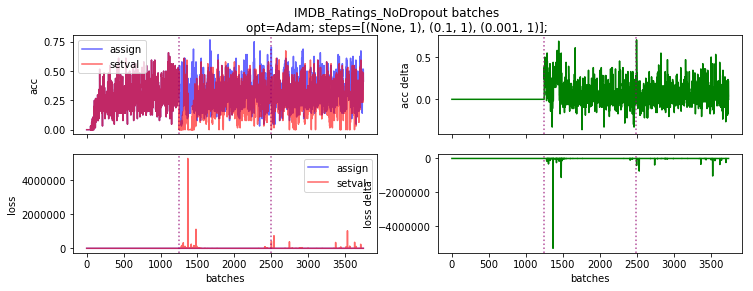

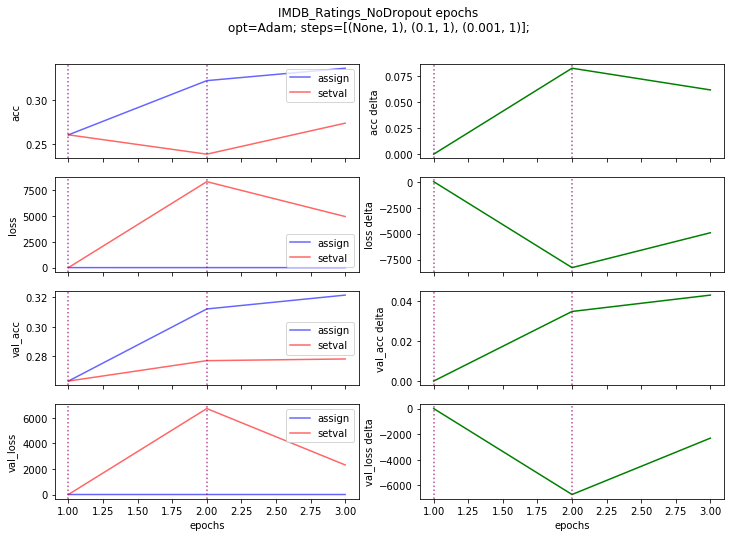

In [122]:
LRTester(IMDB_Ratings_NoDropout).run(steps=[None, 0.1, 0.001]).makefigs()

### CPU Results: IMDB Sentiment Analysis CNN

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 407s - loss: 0.5309 - acc: 0.9658 - val_loss: 7.4163 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 472s - loss: 0.9916 - acc: 0.4496 - val_loss: 7.9812 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 436s - loss: 0.4801 - acc: 0.9708 - val_loss: 8.0331 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 569s - loss: 4.5091 - acc: 0.5000 - val_loss: 1.1871 - val_acc: 0.5000


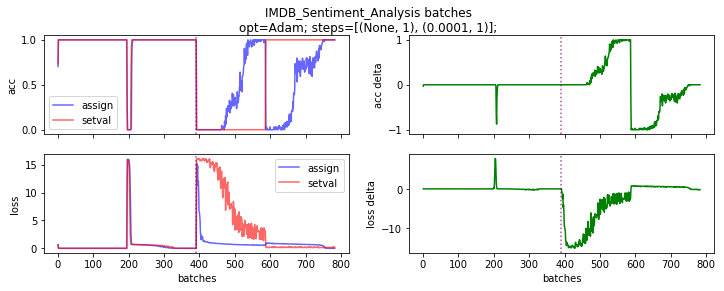

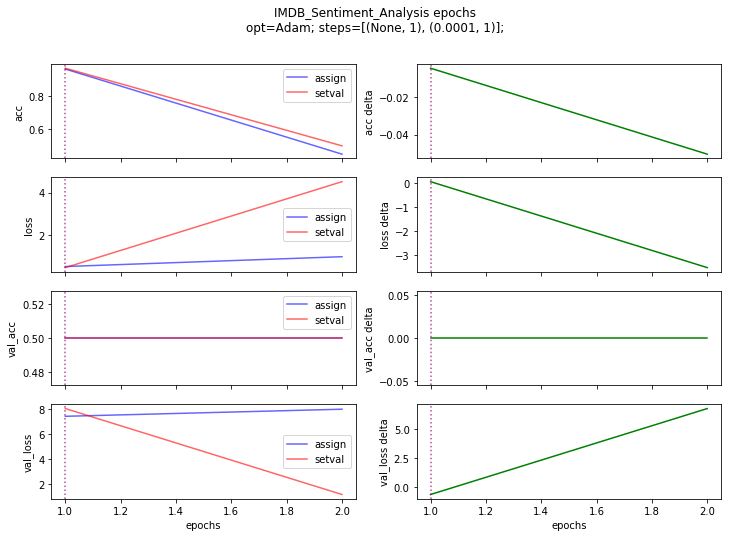

In [164]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=True)
LRTester(IMDB_Sentiment_Analysis).run(steps=[None, 1e-4], step_callback=step_callback).makefigs()

### CPU Results: IMDB Sentiment Analysis CNN (No Dropout)

### CPU Results: IMDB Sentiment Analysis Multi CNN

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 819s - loss: 7.9731 - acc: 0.4978 - val_loss: 7.9710 - val_acc: 0.5000
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 862s - loss: 7.9731 - acc: 0.4978 - val_loss: 7.9710 - val_acc: 0.5000


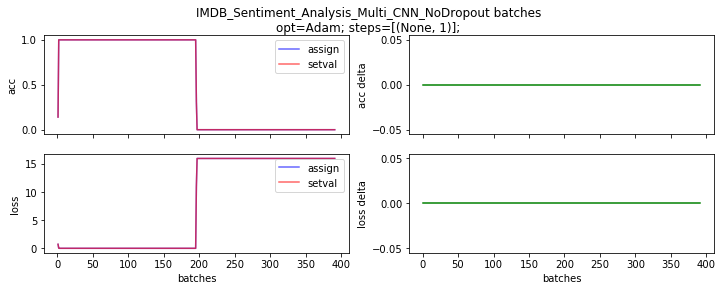

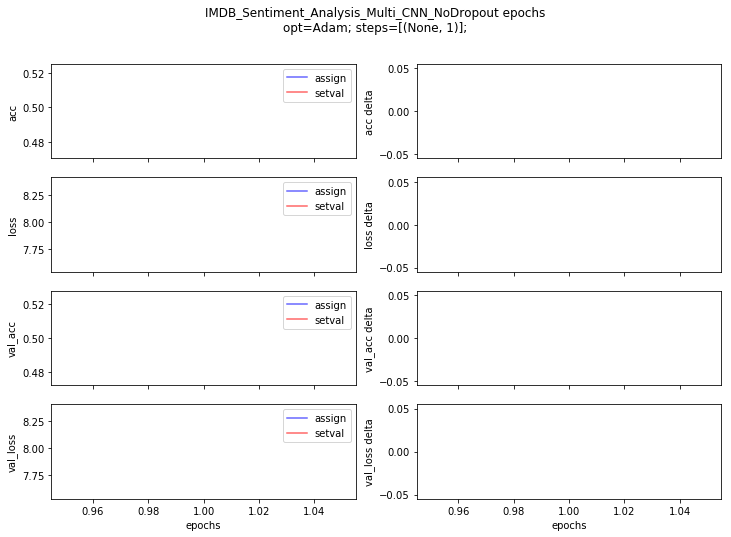

In [153]:
step_callback = set_layer_trainable(on_step=2, layer=0, trainable=False)
LRTester(IMDB_Sentiment_Analysis_Multi_CNN).run(steps=[None, 1e-5], step_callback=step_callback).makefigs()

### CPU Results: IMDB Sentiment Analysis Multi CNN (No Dropout)

### CPU Results: Nietzsche 3-char model

Epoch 1/4
200297/200297 [==============================] - 49s - loss: 4.4180 - acc: 0.1032    
Epoch 2/4
200297/200297 [==============================] - 59s - loss: 4.3003 - acc: 0.1523    
Epoch 3/4
200297/200297 [==============================] - 71s - loss: 4.0547 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 79s - loss: 3.6775 - acc: 0.1524    
Epoch 1/4
200297/200297 [==============================] - 86s - loss: 3.3536 - acc: 0.1524    
Epoch 2/4
200297/200297 [==============================] - 88s - loss: 3.2058 - acc: 0.1524    
Epoch 3/4
200297/200297 [==============================] - 52s - loss: 3.1462 - acc: 0.1524    
Epoch 4/4
200297/200297 [==============================] - 84s - loss: 3.1189 - acc: 0.1524    - ETA: 0s - loss: 3.
Epoch 1/4
200297/200297 [==============================] - 84s - loss: 4.4180 - acc: 0.1032    
Epoch 2/4
200297/200297 [==============================] - 88s - loss: 4.3003 - acc: 0.1523    
Epoch 3/4
200297/200

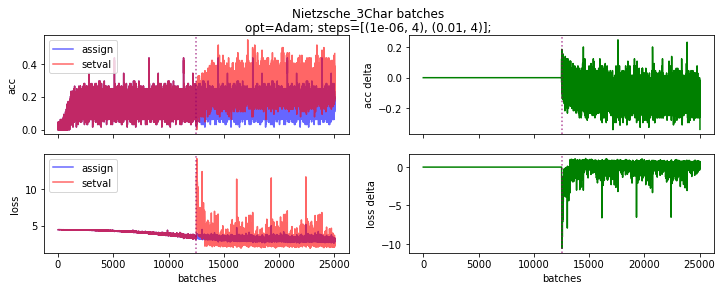

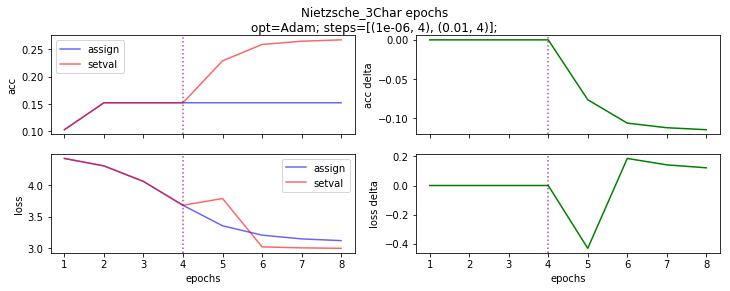

In [184]:
t = LRTester(Nietzsche_3Char).run(steps=[(0.000001, 4), (0.01, 4)]).makefigs()

In [191]:
nietzsche_compare_3char(t.models[0], t.models[1], inputs=['phi', ' th', ' an'])

[(' ', 'n'), (' ', 'e'), (' ', ' ')]

### CPU Results: Nietzsche RNN returing sequences

Epoch 1/4
75110/75110 [==============================] - 50s - loss: 2.4418 - acc: 0.3151    
Epoch 2/4
75110/75110 [==============================] - 50s - loss: 2.0191 - acc: 0.4092    
Epoch 3/4
75110/75110 [==============================] - 51s - loss: 1.8954 - acc: 0.4399    
Epoch 4/4
75110/75110 [==============================] - 56s - loss: 1.8315 - acc: 0.4559    
Epoch 1/4
75110/75110 [==============================] - 58s - loss: 1.7917 - acc: 0.4662    
Epoch 2/4
75110/75110 [==============================] - 64s - loss: 1.7636 - acc: 0.4730    
Epoch 3/4
75110/75110 [==============================] - 62s - loss: 1.7427 - acc: 0.4776    
Epoch 4/4
75110/75110 [==============================] - 68s - loss: 1.7264 - acc: 0.4816    
Epoch 1/4
75110/75110 [==============================] - 69s - loss: 2.4418 - acc: 0.3151    
Epoch 2/4
75110/75110 [==============================] - 71s - loss: 2.0191 - acc: 0.4092    
Epoch 3/4
75110/75110 [==============================] - 70s

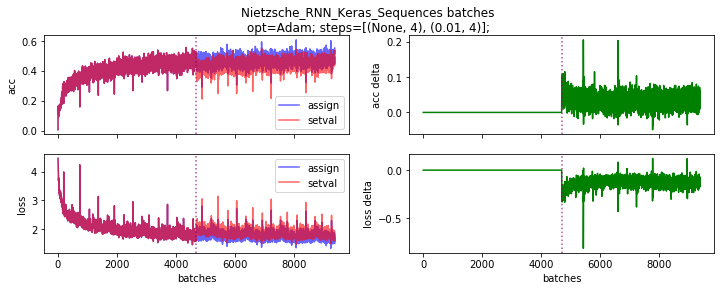

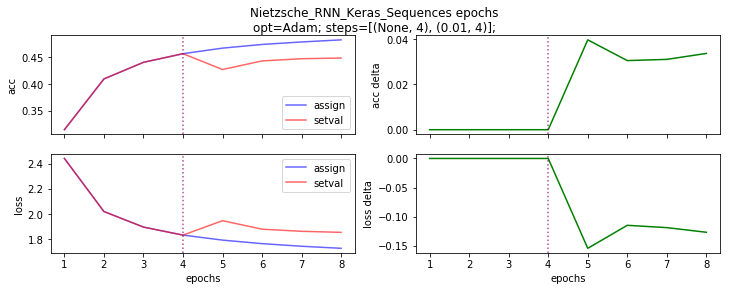

In [15]:
t = LRTester(Nietzsche_RNN_Keras_Sequences).run(steps=[(None, 4), (0.01, 4)]).makefigs()

In [16]:
nietzsche_get_nexts_keras(t.models[0], ' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


['t', 'h', 'e', 's', ' ', 's', 'n', ' ']

In [17]:
nietzsche_get_nexts_keras(t.models[1], ' this is')

[' ', 't', 'h', 'i', 's', ' ', 'i', 's']


['t', 'h', 'e', 's', ' ', 's', 'n', ' ']